# Exploratory Data Analysis — France Grid Stress Prediction (Day-Ahead, D+1)


## Notebook objectives


- Understand the temporal structure of national electricity load and generation  
- Validate data integrity (time axis, missingness, DST, outliers)  
- Analyze demand-side (consumption) and supply-side (production) separately  
- Translate EDA findings into clear modeling decisions for day-ahead forecasting  


# 0. Executive overview


Ensuring the Project Root as the Working Directory


In [1]:
import os  # OS utilities for working with directories

# If the notebook is executed from the notebooks/ folder,
# move up one level to set the project root as the working directory
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

# Print the current working directory for verification
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /home/onyxia/work/france-grid-stress-prediction


### Note on data format and preprocessing choices

Some historical RTE datasets are distributed as large Excel (`.xls`) files with
heterogeneous and partially non-tabular structures. This is notably the case for:

- historical electricity consumption files  
  (e.g. `Historique_consommation_INST_1997.xls`),
- historical production realisation files  
  (e.g. `RealisationDonneesProduction_2015.xls`).

These Excel files may contain empty rows, repeated headers, merged cells, or
ambiguous time encodings, which makes direct exploratory analysis fragile and
hard to reproduce.

To ensure **robustness, clarity, and reproducibility**, these datasets were first
converted into clean, flat CSV files using **two dedicated Python preprocessing scripts**:
one for consumption data and one for production realisation data.

This conversion step is strictly a **format normalization and light cleaning stage**
(no aggregation or feature engineering), and preserves the original information
content of the source files.

All exploratory analyses presented in this notebook are therefore conducted on
the CSV representations derived from the original Excel sources, allowing the EDA
to focus on data understanding rather than Excel-specific parsing issues.


## 0.1 Dataset snapshot

This section provides a high-level snapshot of the dataset used for exploratory analysis.

The objective is to:
- clearly identify the **time coverage**,
- infer the **native temporal frequency**,
- report the **size and structure** of the dataset,
- automatically detect the **main variable families** (load, weather, generation).

This snapshot acts as a reference point for all subsequent analyses.


In [38]:
from __future__ import annotations

from pathlib import Path
import pandas as pd
import numpy as np

def load_csv_or_excel(path: Path) -> pd.DataFrame:
    if path.suffix.lower() in [".xls", ".xlsx"]:
        return pd.read_excel(path)
    return pd.read_csv(path)

def parse_dt(df: pd.DataFrame, col: str) -> pd.Series:
    return pd.to_datetime(df[col], errors="coerce", utc=True)

def infer_native_resolution(
    df: pd.DataFrame,
    dt_col: str,
    group_cols: list[str] | None = None,
    ignore_zero: bool = True
) -> dict:
    """
    Infers the native time resolution by taking the most common positive delta
    within each series (group), then aggregating.

    Returns: {resolution_seconds, resolution_label, diagnostics}
    """
    d = df.copy()
    d[dt_col] = parse_dt(d, dt_col)
    d = d.dropna(subset=[dt_col])

    # Sort and compute deltas within each series
    if group_cols:
        d = d.sort_values(group_cols + [dt_col])
        deltas = (
            d.groupby(group_cols)[dt_col]
             .diff()
             .dt.total_seconds()
        )
    else:
        d = d.sort_values(dt_col)
        deltas = d[dt_col].diff().dt.total_seconds()

    deltas = deltas.dropna()

    if ignore_zero:
        deltas = deltas[deltas > 0]

    if len(deltas) == 0:
        return {
            "resolution_seconds": None,
            "resolution_label": "Unknown (no positive deltas)",
            "diagnostics": {"n_deltas": 0}
        }

    # Most common delta (mode)
    vc = deltas.round().astype("int64").value_counts()
    res_s = int(vc.index[0])

    def label(sec: int) -> str:
        if sec == 900:  return "15-minute"
        if sec == 1800: return "30-minute"
        if sec == 3600: return "Hourly"
        if sec % 3600 == 0: return f"{sec//3600}-hour"
        if sec % 60 == 0:   return f"{sec//60}-minute"
        return f"{sec}-second"

    return {
        "resolution_seconds": res_s,
        "resolution_label": label(res_s),
        "diagnostics": {
            "top_deltas_seconds": vc.head(5).to_dict(),
            "n_deltas_used": int(len(deltas))
        }
    }

def detect_key_variables(columns: list[str]) -> dict[str, list[str]]:
    mapping = {
        "load / consumption": ["consumption", "conso", "load"],
        "temperature": ["temp", "temperature"],
        "wind": ["wind", "eolien"],
        "solar": ["solar", "pv", "radiation"],
        "nuclear": ["nuclear"],
        "hydro": ["hydro"],
        "thermal": ["thermal", "gas", "coal"],
        "installed capacity": ["installed", "capacity", "capacite"],
    }
    out = {}
    for group, kws in mapping.items():
        hits = [c for c in columns if any(kw in c.lower() for kw in kws)]
        if hits:
            out[group] = hits
    return out


### 0.1.1 Weather — 32 cities (historical archive)

This subsection provides a snapshot of the **raw weather data** extracted from the Open-Meteo
historical archive for 32 representative French agglomerations.

The analysis is performed on a **single representative yearly file**, as all years share
the same structure and temporal resolution.


In [39]:
PATH_WEATHER = Path("/home/onyxia/work/france-grid-stress-prediction/data/raw/weather/weather_32_cities_2015.csv")
# or: ".../weather_32_cities_meteofrance_7past_7future.csv"

dfw = load_csv_or_excel(PATH_WEATHER)

freq = infer_native_resolution(dfw, dt_col="date", group_cols=["city"])

snapshot_weather = {
    "Dataset": "Weather (32 cities)",
    "File": str(PATH_WEATHER),
    "Start": parse_dt(dfw, "date").min(),
    "End": parse_dt(dfw, "date").max(),
    "Resolution": freq["resolution_label"],
    "Rows": len(dfw),
    "Columns": len(dfw.columns),
    "Cities": int(dfw["city"].nunique()),
    "Key variables": detect_key_variables(list(dfw.columns)),
    "Diagnostics": freq["diagnostics"],
}
snapshot_weather


{'Dataset': 'Weather (32 cities)',
 'File': '/home/onyxia/work/france-grid-stress-prediction/data/raw/weather/weather_32_cities_2015.csv',
 'Start': Timestamp('2015-01-01 00:00:00+0000', tz='UTC'),
 'End': Timestamp('2015-12-31 23:00:00+0000', tz='UTC'),
 'Resolution': 'Hourly',
 'Rows': 280320,
 'Columns': 7,
 'Cities': 32,
 'Key variables': {'temperature': ['temperature_2m'],
  'wind': ['wind_speed_10m'],
  'solar': ['direct_radiation', 'diffuse_radiation']},
 'Diagnostics': {'top_deltas_seconds': {3600: 280288},
  'n_deltas_used': 280288}}

### 0.1.2 Weather — 7 past days + 7 forecast days (Météo-France)

This dataset combines **recent historical observations and short-term forecasts**
from the Météo-France Open-Meteo endpoint.

It is designed for **near real-time Day-Ahead forecasting**, not for long-term training.


In [40]:
PATH_WEATHER = Path("/home/onyxia/work/france-grid-stress-prediction/data/raw/weather/weather_32_cities_meteofrance_7past_7future.csv")

dfw = load_csv_or_excel(PATH_WEATHER)

freq = infer_native_resolution(dfw, dt_col="date", group_cols=["city"])

snapshot_weather = {
    "Dataset": "Weather (32 cities)",
    "File": str(PATH_WEATHER),
    "Start": parse_dt(dfw, "date").min(),
    "End": parse_dt(dfw, "date").max(),
    "Resolution": freq["resolution_label"],
    "Rows": len(dfw),
    "Columns": len(dfw.columns),
    "Cities": int(dfw["city"].nunique()),
    "Key variables": detect_key_variables(list(dfw.columns)),
    "Diagnostics": freq["diagnostics"],
}
snapshot_weather


{'Dataset': 'Weather (32 cities)',
 'File': '/home/onyxia/work/france-grid-stress-prediction/data/raw/weather/weather_32_cities_meteofrance_7past_7future.csv',
 'Start': Timestamp('2025-12-21 00:00:00+0000', tz='UTC'),
 'End': Timestamp('2026-01-03 23:00:00+0000', tz='UTC'),
 'Resolution': 'Hourly',
 'Rows': 10752,
 'Columns': 7,
 'Cities': 32,
 'Key variables': {'temperature': ['temperature_2m'],
  'wind': ['wind_speed_10m'],
  'solar': ['direct_radiation', 'diffuse_radiation']},
 'Diagnostics': {'top_deltas_seconds': {3600: 10720}, 'n_deltas_used': 10720}}

### 0.1.3 — Electricity consumption (RTE)

The snapshot is computed on one **representative yearly file** produced by the preprocessing pipeline
(`data/interim/consommation/consommation_<year>_long.csv`), which already follows a clean *long* time-series format
(one row per timestamp).

Because RTE historical files may contain daylight-saving irregularities or missing timestamps,
the time resolution is **not inferred using pandas built-in frequency detection**.
Instead, we compute the **modal time delta** between consecutive timestamps, which provides a robust estimate
of the effective resolution.


In [41]:
# ==========================================================
# Optional: Snapshot across ALL consumption long CSV files
# (1996-2025) in data/interim/consommation
# ==========================================================

from pathlib import Path
import pandas as pd
import numpy as np

CONS_DIR = Path("/home/onyxia/work/france-grid-stress-prediction/data/interim/consommation")
files = sorted(CONS_DIR.glob("consommation_*_long.csv"))

def resolution_mode_minutes(dt: pd.Series) -> tuple[str, float | None, float | None]:
    dt = pd.to_datetime(dt, errors="coerce")
    dt = dt.dropna().sort_values()
    if len(dt) < 2:
        return ("Unknown", None, None)
    delta = dt.diff().dropna()
    mins = (delta.dt.total_seconds() / 60).round(6)
    if mins.empty:
        return ("Unknown", None, None)
    mode = float(mins.mode().iloc[0])
    share = float((mins == mode).mean())
    return (f"{mode:g} min", mode, share)

rows = []
for p in files:
    try:
        df = pd.read_csv(p, usecols=lambda c: c.lower() in ("datetime", "dt", "timestamp", "date"))
    except Exception:
        df = pd.read_csv(p)

    # datetime col detection
    dt_col = None
    for c in df.columns:
        if c.lower() in ("datetime", "dt", "timestamp"):
            dt_col = c
            break
    if dt_col is None:
        # fallback: first column
        dt_col = df.columns[0]

    dt = pd.to_datetime(df[dt_col], errors="coerce")
    start = dt.min()
    end = dt.max()

    # get file shape cheaply (read only header + count lines)
    # (fallback: full read if needed)
    try:
        full = pd.read_csv(p)
        n_rows, n_cols = full.shape
        cols = full.columns.tolist()
    except Exception:
        n_rows, n_cols = (None, None)
        cols = []

    res_label, res_mode, res_share = resolution_mode_minutes(dt)

    rows.append({
        "file": p.name,
        "start": start,
        "end": end,
        "rows": n_rows,
        "cols": n_cols,
        "resolution_mode_min": res_mode,
        "resolution_quality_share": res_share,
        "resolution_label": res_label,
    })

snapshot_all = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)
snapshot_all


,file,start,end,rows,cols,resolution_mode_min,resolution_quality_share,resolution_label
0,consommation_1996_long.csv,1996-01-01,1996-12-31 23:30:00,17568,6,30.0,1.000000,30 min
1,consommation_1997_long.csv,1997-01-01,1997-12-31 23:30:00,17520,6,30.0,1.000000,30 min
2,consommation_1998_long.csv,1998-01-01,1998-12-31 23:30:00,17520,6,30.0,1.000000,30 min
3,consommation_1999_long.csv,1999-01-01,1999-12-31 23:30:00,17520,6,30.0,1.000000,30 min
4,consommation_2000_long.csv,2000-01-01,2000-12-31 23:30:00,17568,6,30.0,1.000000,30 min
5,consommation_2001_long.csv,2001-01-01,2001-12-31 23:30:00,17520,6,30.0,1.000000,30 min
6,consommation_2002_long.csv,2002-01-01,2002-12-31 23:30:00,17520,6,30.0,1.000000,30 min
7,consommation_2003_long.csv,2003-01-01,2003-12-31 23:30:00,17520,6,30.0,1.000000,30 min
8,consommation_2004_long.csv,2004-01-01,2004-12-31 23:30:00,17568,6,30.0,1.000000,30 min
9,consommation_2005_long.csv,2005-01-01,2005-12-31 23:30:00,17520,6,30.0,1.000000,30 min


### 0.1.4 Dataset snapshot — RTE realised consumption (Year-To-Date)

In addition to the historical consumption archives, the project relies on a **near real-time realised consumption feed**
retrieved via the RTE API and stored as a CSV file.

This Year-To-Date (YTD) dataset is used to monitor **recent consumption dynamics**, validate the forecasting pipeline
close to real time, and ensure continuity between historical data and **day-ahead operational forecasting**.

Given its **continuous updates** and **interval-based time structure**, a dedicated snapshot is performed to assess
the **temporal coverage**, infer the **effective time resolution**, and verify structural consistency with the
historical consumption datasets.


In [47]:
import pandas as pd
import numpy as np

PATH = "/home/onyxia/work/france-grid-stress-prediction/data/raw/consommation/2025/rte_consumption_realised_ytd.csv"

# --- Load ---
df = pd.read_csv(PATH)
df.columns = df.columns.str.strip()

# --- Validate schema ---
expected = {"start_date", "end_date"}
missing = expected - set(df.columns)
if missing:
    raise ValueError(f"Missing columns {missing}. Available columns: {list(df.columns)}")

# --- Parse datetimes (keep tz -> convert to UTC for clean diffs) ---
df["start_date"] = pd.to_datetime(df["start_date"], errors="coerce", utc=True)
df["end_date"]   = pd.to_datetime(df["end_date"], errors="coerce", utc=True)
if "updated_date" in df.columns:
    df["updated_date"] = pd.to_datetime(df["updated_date"], errors="coerce", utc=True)

# --- Interval duration (minutes) ---
interval_td = df["end_date"] - df["start_date"]
interval_min = interval_td.dt.total_seconds() / 60
interval_min_clean = interval_min.dropna()

# --- Resolution stats ---
mode_delta = float(interval_min_clean.mode().iloc[0])
mean_delta = float(interval_min_clean.mean())
median_delta = float(interval_min_clean.median())
std_delta = float(interval_min_clean.std())

resolution_table = (
    interval_min_clean.round(6)
    .value_counts()
    .sort_index()
    .rename("count")
    .to_frame()
)
resolution_table["share"] = resolution_table["count"] / resolution_table["count"].sum()

# --- Coverage & grid checks ---
start_min = df["start_date"].min()
end_max   = df["end_date"].max()

span_minutes = (end_max - start_min).total_seconds() / 60
expected_points = int(round(span_minutes / mode_delta)) if span_minutes >= 0 else 0

unique_starts = df["start_date"].nunique(dropna=True)
missing_points = expected_points - unique_starts
missing_share = (missing_points / expected_points) if expected_points > 0 else np.nan

# gaps between consecutive start timestamps
dt_sorted = df["start_date"].dropna().sort_values()
gaps_min = dt_sorted.diff().dt.total_seconds().div(60).dropna()
n_big_gaps = int((gaps_min > mode_delta + 1e-9).sum())
max_gap = float(gaps_min.max()) if len(gaps_min) else np.nan

# duplicates on start_date
dupe_start = int(df.duplicated(subset=["start_date"]).sum())

# tiling check: end_date should equal next start_date (perfect chaining)
s = df.sort_values("start_date").reset_index(drop=True)
tiling_sec = (s["end_date"] - s["start_date"].shift(-1)).dt.total_seconds().dropna()
n_bad_tiling = int((tiling_sec.abs() > 1e-6).sum())
max_tiling_mismatch_sec = float(tiling_sec.abs().max()) if len(tiling_sec) else 0.0

# --- Value sanity ---
value_col = "consumption_mw" if "consumption_mw" in df.columns else None
if value_col:
    null_values = int(df[value_col].isna().sum())
    neg_values  = int((df[value_col] < 0).sum())
    vmin, vmed, vmax = (float(df[value_col].min()),
                        float(df[value_col].median()),
                        float(df[value_col].max()))
else:
    null_values = neg_values = vmin = vmed = vmax = None

# --- Summary object (compact but rich) ---
summary = {
    "file": PATH,
    "rows": int(len(df)),
    "coverage_utc": f"{start_min} -> {end_max}",
    "dominant_interval_min": mode_delta,
    "interval_stats_min (mean/median/std/min/max)": (
        mean_delta,
        median_delta,
        std_delta,
        float(interval_min_clean.min()),
        float(interval_min_clean.max()),
    ),
    "unique_start_points": int(unique_starts),
    "expected_points_from_span": int(expected_points),
    "missing_grid_points (count/share)": (int(missing_points), f"{missing_share:.2%}"),
    "duplicates_on_start_date": int(dupe_start),
    "gaps_gt_dominant (count)": int(n_big_gaps),
    "max_gap_between_starts_min": max_gap,
    "bad_tiling_end_vs_next_start (count)": int(n_bad_tiling),
    "max_tiling_mismatch_seconds": max_tiling_mismatch_sec,
    "top_resolutions": resolution_table.head(10),
}

if value_col:
    summary.update({
        "value_col": value_col,
        "null_values": null_values,
        "negative_values": neg_values,
        "consumption_min/median/max_mw": (vmin, vmed, vmax),
    })

summary


{'file': '/home/onyxia/work/france-grid-stress-prediction/data/raw/consommation/2025/rte_consumption_realised_ytd.csv',
 'rows': 34398,
 'coverage_utc': '2024-12-31 23:00:00+00:00 -> 2025-12-27 23:00:00+00:00',
 'dominant_interval_min': 15.0,
 'interval_stats_min (mean/median/std/min/max)': (15.0,
  15.0,
  0.4575156612435953,
  -45.0,
  75.0),
 'unique_start_points': 34397,
 'expected_points_from_span': 34656,
 'missing_grid_points (count/share)': (259, '0.75%'),
 'duplicates_on_start_date': 1,
 'gaps_gt_dominant (count)': 142,
 'max_gap_between_starts_min': 1470.0,
 'bad_tiling_end_vs_next_start (count)': 143,
 'max_tiling_mismatch_seconds': 87300.0,
 'top_resolutions':        count     share
 -45.0      1  0.000029
  15.0  34396  0.999942
  75.0      1  0.000029,
 'value_col': 'consumption_mw',
 'null_values': 0,
 'negative_values': 0,
 'consumption_min/median/max_mw': (29044.0, 47528.0, 86918.0)}

### 0.1.5 RTE realised generation mix (processed long format)

The production “realisation” files are **standardised long-format CSVs** generated from RTE yearly raw exports
(one file per year, one row per *(datetime × technology)*).

We snapshot these processed files to verify:
- **coverage** (min/max datetime, number of days),
- **time granularity** (mode/median interval, missing grid points, irregularities),
- **structural integrity** (duplicates on *(datetime, technology)*, nulls),
- **content sanity** (number of technologies, presence of `Total`, NaN/negative `value_mw`).

This ensures downstream aggregation (by technology, by day/hour) and forecasting features are built on a clean,
consistent production panel.



In [43]:
# === Snapshot — RTE realised generation mix (processed long format) ===
# Assumes yearly processed files like: production_realisation_2017_long.csv
# Columns: datetime,date,year,hour_interval,technology,value_mw

from pathlib import Path
import pandas as pd
import numpy as np

# ---------------------------
# Helpers: time resolution
# ---------------------------
def _as_minutes(delta) -> float:
    if pd.isna(delta):
        return np.nan
    td = pd.to_timedelta(delta)
    return td.total_seconds() / 60.0

def describe_time_index(dt: pd.Series) -> dict:
    s = pd.to_datetime(dt, errors="coerce").dropna().sort_values()
    if s.empty:
        return {"start": None, "end": None, "span_days": np.nan, "mode_min": np.nan,
                "mode_share": np.nan, "median_min": np.nan, "mean_min": np.nan,
                "missing_grid_points": np.nan, "missing_share_vs_grid": np.nan,
                "irregular_intervals_share": np.nan, "duplicates_ts": 0}

    start, end = s.iloc[0], s.iloc[-1]
    span_days = (end - start).total_seconds() / 86400.0

    duplicates_ts = int(s.duplicated().sum())

    deltas = s.diff().dropna()
    if deltas.empty:
        return {"start": start, "end": end, "span_days": span_days, "mode_min": np.nan,
                "mode_share": np.nan, "median_min": np.nan, "mean_min": np.nan,
                "missing_grid_points": np.nan, "missing_share_vs_grid": np.nan,
                "irregular_intervals_share": np.nan, "duplicates_ts": duplicates_ts}

    minutes = deltas.map(_as_minutes)

    mode_min = float(pd.Series(minutes).mode().iloc[0])
    mode_share = float((minutes == mode_min).mean())
    median_min = float(np.nanmedian(minutes))
    mean_min = float(np.nanmean(minutes))

    nonzero = minutes[minutes > 0]
    if len(nonzero) == 0:
        irregular_share = 0.0
    else:
        irregular_share = float((nonzero != mode_min).mean())

    missing_grid_points = np.nan
    missing_share_vs_grid = np.nan
    if mode_share >= 0.90 and mode_min > 0:
        freq = pd.Timedelta(minutes=mode_min)
        grid = pd.date_range(start=start, end=end, freq=freq)
        observed = pd.Index(s.unique())
        missing = grid.difference(observed)
        missing_grid_points = int(len(missing))
        missing_share_vs_grid = float(len(missing) / len(grid)) if len(grid) else 0.0

    return {
        "start": start,
        "end": end,
        "span_days": float(span_days),
        "mode_min": mode_min,
        "mode_share": mode_share,
        "median_min": median_min,
        "mean_min": mean_min,
        "missing_grid_points": missing_grid_points,
        "missing_share_vs_grid": missing_share_vs_grid,
        "irregular_intervals_share": irregular_share,
        "duplicates_ts": duplicates_ts,
    }

# ---------------------------
# Snapshot main
# ---------------------------
def snapshot_generation_mix_processed_long(
    base_dir: str = "/home/onyxia/work/france-grid-stress-prediction",
    rel_dir: str = "data/interim/production",
    pattern: str = "production_realisation_*_long.csv",
    print_each_file: bool = True,
) -> pd.DataFrame:
    """
    Reads all processed long-format generation mix files and prints a compact snapshot.
    Returns a per-file summary dataframe.
    """
    folder = Path(base_dir) / rel_dir
    files = sorted(folder.glob(pattern))

    if not files:
        raise FileNotFoundError(f"No files found in: {folder} (pattern: {pattern})")

    rows = []
    for fp in files:
        df = pd.read_csv(fp, parse_dates=["datetime"])

        # Coverage & granularity
        t = describe_time_index(df["datetime"])

        # Structural integrity
        n_rows = int(len(df))
        n_null_any = int(df.isna().sum().sum())
        n_dup_key = int(df.duplicated(subset=["datetime", "technology"]).sum()) if {"datetime","technology"}.issubset(df.columns) else np.nan

        # Content sanity
        tech_n = int(df["technology"].nunique(dropna=True)) if "technology" in df.columns else np.nan
        has_total = bool((df["technology"] == "Total").any()) if "technology" in df.columns else False

        v = pd.to_numeric(df["value_mw"], errors="coerce") if "value_mw" in df.columns else pd.Series([], dtype=float)
        n_nan_v = int(v.isna().sum()) if n_rows else 0
        n_neg_v = int((v < 0).sum()) if n_rows else 0

        n_days = int(pd.to_datetime(df["date"], errors="coerce").nunique(dropna=True)) if "date" in df.columns else np.nan

        row = {
            "file": fp.name,
            "rows": n_rows,
            "start": t["start"],
            "end": t["end"],
            "span_days": t["span_days"],
            "mode_interval_min": t["mode_min"],
            "mode_share": t["mode_share"],
            "median_interval_min": t["median_min"],
            "mean_interval_min": t["mean_min"],
            "missing_grid_points": t["missing_grid_points"],
            "missing_share_vs_grid": t["missing_share_vs_grid"],
            "irregular_intervals_share": t["irregular_intervals_share"],
            "dup_timestamps": t["duplicates_ts"],
            "dup_keys_datetime_tech": n_dup_key,
            "null_cells_total": n_null_any,
            "n_days": n_days,
            "n_technologies": tech_n,
            "has_total": has_total,
            "nan_value_mw": n_nan_v,
            "negative_value_mw": n_neg_v,
            "path": str(fp),
        }
        rows.append(row)

        if print_each_file:
            print("\n" + "=" * 92)
            print(f"File: {fp.name}")
            print(f"- rows: {n_rows:,} | days: {n_days if not pd.isna(n_days) else 'NA'} | techs: {tech_n} | has_total={has_total}")
            print(f"- coverage: {t['start']}  →  {t['end']}  (~{t['span_days']:.2f} days)")
            print(
                f"- granularity (min): mode={t['mode_min']:g} ({t['mode_share']:.1%}), "
                f"median={t['median_min']:g}, mean={t['mean_min']:.2f}, "
                f"irregular={t['irregular_intervals_share']:.2%}"
            )
            if not pd.isna(t["missing_grid_points"]):
                print(
                    f"- grid: missing_points={int(t['missing_grid_points']):,} "
                    f"({t['missing_share_vs_grid']:.2%} of expected grid)"
                )
            print(f"- integrity: dup_ts={t['duplicates_ts']:,} | dup(datetime,technology)={n_dup_key:,} | null_cells={n_null_any:,}")
            print(f"- value_mw: NaN={n_nan_v:,} | negative={n_neg_v:,}")

    summary = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)

    # Always print a final one-line recap so you "see something" even if print_each_file=False
    print("\n" + "-" * 92)
    print(f"Processed generation mix snapshot: {len(summary)} file(s) scanned from {folder}")
    print("-" * 92)

    return summary


# --- Run (this is what was missing if you saw 'nothing') ---
generation_mix_summary = snapshot_generation_mix_processed_long(
    base_dir="/home/onyxia/work/france-grid-stress-prediction",
    rel_dir="data/interim/production",
    pattern="production_realisation_*_long.csv",
    print_each_file=True,
)

generation_mix_summary



File: production_realisation_2015_long.csv
- rows: 105,120 | days: 365 | techs: 12 | has_total=True
- coverage: 2015-01-01 00:00:00  →  2015-12-31 23:00:00  (~364.96 days)
- granularity (min): mode=0 (91.7%), median=0, mean=5.00, irregular=100.00%
- integrity: dup_ts=96,360 | dup(datetime,technology)=0 | null_cells=20
- value_mw: NaN=20 | negative=3,976

File: production_realisation_2016_long.csv
- rows: 105,408 | days: 366 | techs: 12 | has_total=True
- coverage: 2016-01-01 00:00:00  →  2016-12-31 23:00:00  (~365.96 days)
- granularity (min): mode=0 (91.7%), median=0, mean=5.00, irregular=100.00%
- integrity: dup_ts=96,624 | dup(datetime,technology)=0 | null_cells=96
- value_mw: NaN=96 | negative=4,798

File: production_realisation_2017_long.csv
- rows: 105,120 | days: 365 | techs: 12 | has_total=True
- coverage: 2017-01-01 00:00:00  →  2017-12-31 23:00:00  (~364.96 days)
- granularity (min): mode=0 (91.7%), median=0, mean=5.00, irregular=100.00%
- integrity: dup_ts=96,360 | dup(date

,file,rows,start,end,span_days,mode_interval_min,mode_share,median_interval_min,mean_interval_min,missing_grid_points,...,irregular_intervals_share,dup_timestamps,dup_keys_datetime_tech,null_cells_total,n_days,n_technologies,has_total,nan_value_mw,negative_value_mw,path
0,production_realisation_2015_long.csv,105120,2015-01-01,2015-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,20,365,12,True,20,3976,/home/onyxia/work/france-grid-stress-predictio...
1,production_realisation_2016_long.csv,105408,2016-01-01,2016-12-31 23:00:00,365.958333,0.0,0.916675,0.0,4.999478,NaN,...,1.0,96624,0,96,366,12,True,96,4798,/home/onyxia/work/france-grid-stress-predictio...
2,production_realisation_2017_long.csv,105120,2017-01-01,2017-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,26,365,12,True,26,4557,/home/onyxia/work/france-grid-stress-predictio...
3,production_realisation_2018_long.csv,105120,2018-01-01,2018-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,24,365,12,True,24,4681,/home/onyxia/work/france-grid-stress-predictio...
4,production_realisation_2019_long.csv,105120,2019-01-01,2019-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,24,365,12,True,24,4521,/home/onyxia/work/france-grid-stress-predictio...
5,production_realisation_2020_long.csv,105408,2020-01-01,2020-12-31 23:00:00,365.958333,0.0,0.916675,0.0,4.999478,NaN,...,1.0,96624,0,108,366,12,True,108,4317,/home/onyxia/work/france-grid-stress-predictio...
6,production_realisation_2021_long.csv,105120,2021-01-01,2021-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,12,365,12,True,12,4021,/home/onyxia/work/france-grid-stress-predictio...
7,production_realisation_2022_long.csv,105120,2022-01-01,2022-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,12,365,12,True,12,4311,/home/onyxia/work/france-grid-stress-predictio...
8,production_realisation_2023_long.csv,108816,2023-01-01,2023-12-31 23:00:00,364.958333,0.0,0.919506,0.0,4.829665,NaN,...,1.0,100056,0,740,365,13,True,740,3997,/home/onyxia/work/france-grid-stress-predictio...
9,production_realisation_2024_long.csv,114192,2024-01-01,2024-12-31 23:00:00,365.958333,0.0,0.923085,0.0,4.614900,NaN,...,1.0,105408,0,47,366,13,True,47,3951,/home/onyxia/work/france-grid-stress-predictio...


### 0.1.6 Dataset snapshot — RTE realised generation mix (API, 15-min, YTD)

This CSV corresponds to a **near real-time Year-To-Date feed** of RTE *actual electricity generation*
retrieved via the official API, with a **15-minute time resolution**.
In the current setup, the dataset is restricted to **SOLAR** and **WIND** production types.

A dedicated snapshot is performed to:
- assess **data freshness** (latest `end_date` and `updated_date` relative to the current time),
- characterise **temporal coverage** (start/end timestamps and number of covered days),
- validate the **time grid structure** (expected 15-minute cadence, missing or irregular intervals),
- check **structural integrity** (duplicate intervals, missing values),
- ensure **content sanity** (NaN or negative `value_mw`, consistency across production types).

This step guarantees that the most recent generation data can be safely integrated
into the real-time forecasting and grid stress assessment pipeline.


In [44]:
# === Snapshot — RTE realised generation mix (API, 15-min, YTD) ===
# File schema (expected):
# production_type, production_subtype, start_date, end_date, updated_date, value_mw

from pathlib import Path
import pandas as pd
import numpy as np

API_FILE = Path("/home/onyxia/work/france-grid-stress-prediction/data/raw/production/rte_actual_generation_mix_15min_ytd_solar_wind.csv")

def _to_dt(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce", utc=False)

def _timedelta_minutes(td) -> float:
    if pd.isna(td):
        return np.nan
    return pd.to_timedelta(td).total_seconds() / 60.0

def describe_grid(times: pd.Series) -> dict:
    """
    Analyse the time grid using a sorted unique timestamp series.
    Returns: mode/median/mean interval (minutes), missing points vs inferred grid,
    and irregular interval share.
    """
    t = pd.to_datetime(times, errors="coerce").dropna().drop_duplicates().sort_values()
    if t.empty or len(t) < 2:
        return {
            "t_start": None, "t_end": None, "span_days": np.nan,
            "mode_min": np.nan, "mode_share": np.nan,
            "median_min": np.nan, "mean_min": np.nan,
            "missing_points": np.nan, "missing_share": np.nan,
            "irregular_share": np.nan,
        }

    deltas = t.diff().dropna()
    mins = deltas.map(_timedelta_minutes)

    mode_min = float(pd.Series(mins).mode().iloc[0])
    mode_share = float((mins == mode_min).mean())
    median_min = float(np.nanmedian(mins))
    mean_min = float(np.nanmean(mins))

    nonzero = mins[mins > 0]
    irregular_share = float((nonzero != mode_min).mean()) if len(nonzero) else 0.0

    t_start, t_end = t.iloc[0], t.iloc[-1]
    span_days = float((t_end - t_start).total_seconds() / 86400.0)

    missing_points = np.nan
    missing_share = np.nan
    # Build an expected grid only if cadence is clearly dominant
    if mode_share >= 0.90 and mode_min > 0:
        freq = pd.Timedelta(minutes=mode_min)
        grid = pd.date_range(t_start, t_end, freq=freq)
        missing = pd.Index(grid).difference(pd.Index(t))
        missing_points = int(len(missing))
        missing_share = float(len(missing) / len(grid)) if len(grid) else 0.0

    return {
        "t_start": t_start,
        "t_end": t_end,
        "span_days": span_days,
        "mode_min": mode_min,
        "mode_share": mode_share,
        "median_min": median_min,
        "mean_min": mean_min,
        "missing_points": missing_points,
        "missing_share": missing_share,
        "irregular_share": irregular_share,
    }

def snapshot_rte_api_15min(file_path: Path) -> dict:
    df = pd.read_csv(file_path)

    required = {"production_type", "production_subtype", "start_date", "end_date", "updated_date", "value_mw"}
    missing_cols = required.difference(df.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in {file_path.name}: {sorted(missing_cols)}. Found: {list(df.columns)}")

    # Parse timestamps (they are timezone-aware in your CSV)
    df["start_date"] = _to_dt(df["start_date"])
    df["end_date"] = _to_dt(df["end_date"])
    df["updated_date"] = _to_dt(df["updated_date"])
    df["value_mw"] = pd.to_numeric(df["value_mw"], errors="coerce")

    # Basic counts
    n_rows = int(len(df))
    n_types = int(df["production_type"].nunique(dropna=True))
    types = sorted(df["production_type"].dropna().unique().tolist())
    n_subtypes = int(df["production_subtype"].nunique(dropna=True))

    # Coverage: based on measurement window end_date
    grid_info = describe_grid(df["end_date"])

    # Freshness: compare latest end_date and latest updated_date to "now" in Europe/Paris
    now = pd.Timestamp.now(tz="Europe/Paris")
    end_max = df["end_date"].max()
    upd_max = df["updated_date"].max()

    # Ensure tz-aware comparisons
    end_max_local = end_max.tz_convert("Europe/Paris") if getattr(end_max, "tzinfo", None) else end_max.tz_localize("Europe/Paris")
    upd_max_local = upd_max.tz_convert("Europe/Paris") if getattr(upd_max, "tzinfo", None) else upd_max.tz_localize("Europe/Paris")

    lag_end_min = float((now - end_max_local).total_seconds() / 60.0)
    lag_upd_min = float((now - upd_max_local).total_seconds() / 60.0)

    # Integrity
    dup_key = int(df.duplicated(subset=["production_type", "production_subtype", "start_date", "end_date"]).sum())
    null_cells = int(df.isna().sum().sum())
    nan_value = int(df["value_mw"].isna().sum())
    neg_value = int((df["value_mw"] < 0).sum())

    # 15-min window check: end-start should be 15 minutes almost always
    win_min = (df["end_date"] - df["start_date"]).map(_timedelta_minutes)
    win_mode = float(pd.Series(win_min.dropna()).mode().iloc[0]) if win_min.notna().any() else np.nan
    win_mode_share = float((win_min == win_mode).mean()) if win_min.notna().any() else np.nan
    bad_window = int((win_min != 15).sum()) if win_min.notna().any() else 0

    # Per-type coverage summary (min/max and missingness of value_mw)
    by_type = (
        df.groupby("production_type")
          .agg(
              rows=("value_mw", "size"),
              start=("end_date", "min"),
              end=("end_date", "max"),
              nan_value=("value_mw", lambda s: int(pd.to_numeric(s, errors="coerce").isna().sum())),
              neg_value=("value_mw", lambda s: int((pd.to_numeric(s, errors="coerce") < 0).sum())),
              mean_mw=("value_mw", "mean"),
              p50_mw=("value_mw", "median"),
              p95_mw=("value_mw", lambda s: float(np.nanpercentile(s, 95)) if s.notna().any() else np.nan),
              max_mw=("value_mw", "max"),
          )
          .sort_index()
    )

    snap = {
        "file": file_path.name,
        "path": str(file_path),
        "rows": n_rows,
        "production_types": types,
        "n_types": n_types,
        "n_subtypes": n_subtypes,
        "coverage_start": grid_info["t_start"],
        "coverage_end": grid_info["t_end"],
        "span_days": grid_info["span_days"],
        "interval_mode_min": grid_info["mode_min"],
        "interval_mode_share": grid_info["mode_share"],
        "interval_median_min": grid_info["median_min"],
        "interval_mean_min": grid_info["mean_min"],
        "missing_grid_points": grid_info["missing_points"],
        "missing_grid_share": grid_info["missing_share"],
        "irregular_intervals_share": grid_info["irregular_share"],
        "freshness_lag_end_minutes": lag_end_min,
        "freshness_lag_updated_minutes": lag_upd_min,
        "dup_keys": dup_key,
        "null_cells_total": null_cells,
        "nan_value_mw": nan_value,
        "negative_value_mw": neg_value,
        "window_minutes_mode": win_mode,
        "window_minutes_mode_share": win_mode_share,
        "non_15min_windows": bad_window,
    }
    return snap, by_type

def print_snapshot(snap: dict, by_type: pd.DataFrame) -> None:
    print("\n" + "=" * 96)
    print("RTE realised generation mix — API (15-min, YTD) snapshot")
    print("=" * 96)
    print(f"File: {snap['file']}")
    print(f"Path: {snap['path']}")
    print(f"- rows: {snap['rows']:,}")
    print(f"- production_types: {snap['production_types']} (n={snap['n_types']}), subtypes n={snap['n_subtypes']}")
    print(f"- coverage: {snap['coverage_start']}  →  {snap['coverage_end']}  (~{snap['span_days']:.2f} days)")
    print(f"- freshness (Europe/Paris):")
    print(f"    • lag vs latest end_date:     {snap['freshness_lag_end_minutes']:.0f} min (~{snap['freshness_lag_end_minutes']/60:.2f} h)")
    print(f"    • lag vs latest updated_date: {snap['freshness_lag_updated_minutes']:.0f} min (~{snap['freshness_lag_updated_minutes']/60:.2f} h)")
    print("- time grid (based on end_date):")
    print(
        f"    • interval minutes: mode={snap['interval_mode_min']:g} ({snap['interval_mode_share']:.1%}), "
        f"median={snap['interval_median_min']:g}, mean={snap['interval_mean_min']:.2f}"
    )
    print(f"    • irregular intervals share: {snap['irregular_intervals_share']:.2%}")
    if not pd.isna(snap["missing_grid_points"]):
        print(f"    • missing points vs inferred grid: {int(snap['missing_grid_points']):,} ({snap['missing_grid_share']:.2%})")
    print("- measurement window (end_date - start_date):")
    print(f"    • mode={snap['window_minutes_mode']:g} min ({snap['window_minutes_mode_share']:.1%}) | non-15min windows={snap['non_15min_windows']:,}")
    print(f"- integrity: dup_keys={snap['dup_keys']:,} | null_cells={snap['null_cells_total']:,}")
    print(f"- value_mw: NaN={snap['nan_value_mw']:,} | negative={snap['negative_value_mw']:,}")
    print("\nPer production_type summary:")
    display_cols = ["rows", "start", "end", "nan_value", "neg_value", "mean_mw", "p50_mw", "p95_mw", "max_mw"]
    print(by_type[display_cols].to_string())

# --- Run ---
snap, per_type = snapshot_rte_api_15min(API_FILE)
print_snapshot(snap, per_type)

# Optional: keep a 1-row dataframe for later concatenation
rte_api_generation_snapshot_df = pd.DataFrame([snap])
rte_api_generation_snapshot_df


/tmp/ipykernel_52691/2019166923.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(s, errors="coerce", utc=False)
/tmp/ipykernel_52691/2019166923.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(s, errors="coerce", utc=False)
/tmp/ipykernel_52691/2019166923.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please s


RTE realised generation mix — API (15-min, YTD) snapshot
File: rte_actual_generation_mix_15min_ytd_solar_wind.csv
Path: /home/onyxia/work/france-grid-stress-prediction/data/raw/production/rte_actual_generation_mix_15min_ytd_solar_wind.csv
- rows: 67,000
- production_types: ['SOLAR', 'WIND'] (n=2), subtypes n=1
- coverage: 2025-01-01 00:15:00+01:00  →  2025-12-28 00:00:00+01:00  (~360.99 days)
- freshness (Europe/Paris):
    • lag vs latest end_date:     2077 min (~34.62 h)
    • lag vs latest updated_date: 2089 min (~34.82 h)
- time grid (based on end_date):
    • interval minutes: mode=15 (100.0%), median=15, mean=37.48
    • irregular intervals share: 0.04%
    • missing points vs inferred grid: 20,785 (59.98%)
- measurement window (end_date - start_date):
    • mode=15 min (100.0%) | non-15min windows=0
- integrity: dup_keys=0 | null_cells=0
- value_mw: NaN=0 | negative=10

Per production_type summary:
                  rows                      start                        end  na

,file,path,rows,production_types,n_types,n_subtypes,coverage_start,coverage_end,span_days,interval_mode_min,...,irregular_intervals_share,freshness_lag_end_minutes,freshness_lag_updated_minutes,dup_keys,null_cells_total,nan_value_mw,negative_value_mw,window_minutes_mode,window_minutes_mode_share,non_15min_windows
0,rte_actual_generation_mix_15min_ytd_solar_wind...,/home/onyxia/work/france-grid-stress-predictio...,67000,"[SOLAR, WIND]",2,1,2025-01-01 00:15:00+01:00,2025-12-28 00:00:00+01:00,360.989583,15.0,...,0.00036,2077.453745,2089.220411,0,0,0,10,15.0,1.0,0


### 0.1.7 Dataset snapshot — Installed generation capacities (RTE)

This project also relies on **installed generation capacity datasets** published by RTE, which provide
a **structural description of the French power system** by generation technology.

Two complementary document types are used:

- **Historical installed capacities by year**  
  (e.g. `Capacite_installee_production_2022.csv`, available for several years)  
  These files report installed capacity levels (in MW) by production technology for a given year.
  The snapshot confirms:
  - full coverage of major generation technologies (nuclear, wind, solar, hydro, thermal),
  - annual time granularity with one capacity value per technology,
  - consistent units (MW) across all years,
  - smooth year-to-year evolution reflecting structural changes in the generation mix.

- **Installed capacities for the current year**  
  (e.g. `rte_installed_capacities_all_current_year.csv`)  
  This dataset provides the **latest reference capacity levels** used for near real-time analysis.
  The snapshot highlights:
  - the same technology breakdown as in historical files,
  - coherence between current-year capacities and the most recent historical observations,
  - absence of temporal indexing, consistent with a static structural reference.

Given their **small size and simple tabular structure**, these datasets are directly exploitable without
additional preprocessing. They are used to contextualise realised production levels and to interpret
grid stress indicators, rather than as direct time-series inputs to short-term forecasting models.


## 0.2 Top data issues


Summarize any critical issues:
- Missing timestamp blocks
- DST anomalies (23h / 25h days)
- High missing-rate variables
- Extreme or suspicious values


## 0.3 Key findings


Write 3–5 high-level findings in plain language after completing the EDA.


## 0.4 Physical Dashboard: Weather & Energy Correlation (Representative Week)

This visualization validates the physical alignment of our datasets over a winter week in **January 2024**.
All time series have been standardized to **UTC** to ensure perfect synchronization.

The dashboard displays:
1.  **National Consumption (Load):** The demand curve (affected by human activity + heating).
2.  **Renewable Production:** The combined output of Wind and Solar.
3.  **Weighted Temperature:** The primary driver of demand (inverted scale).
4.  **Wind Speed:** The physical driver of wind generation.
5.  **Solar Radiation:** The physical driver of PV generation.

--- Loading & Standardizing Data ---


/tmp/ipykernel_6079/3540778014.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_weather_nat = df_weather.groupby('datetime_utc').apply(weighted_avg).reset_index()


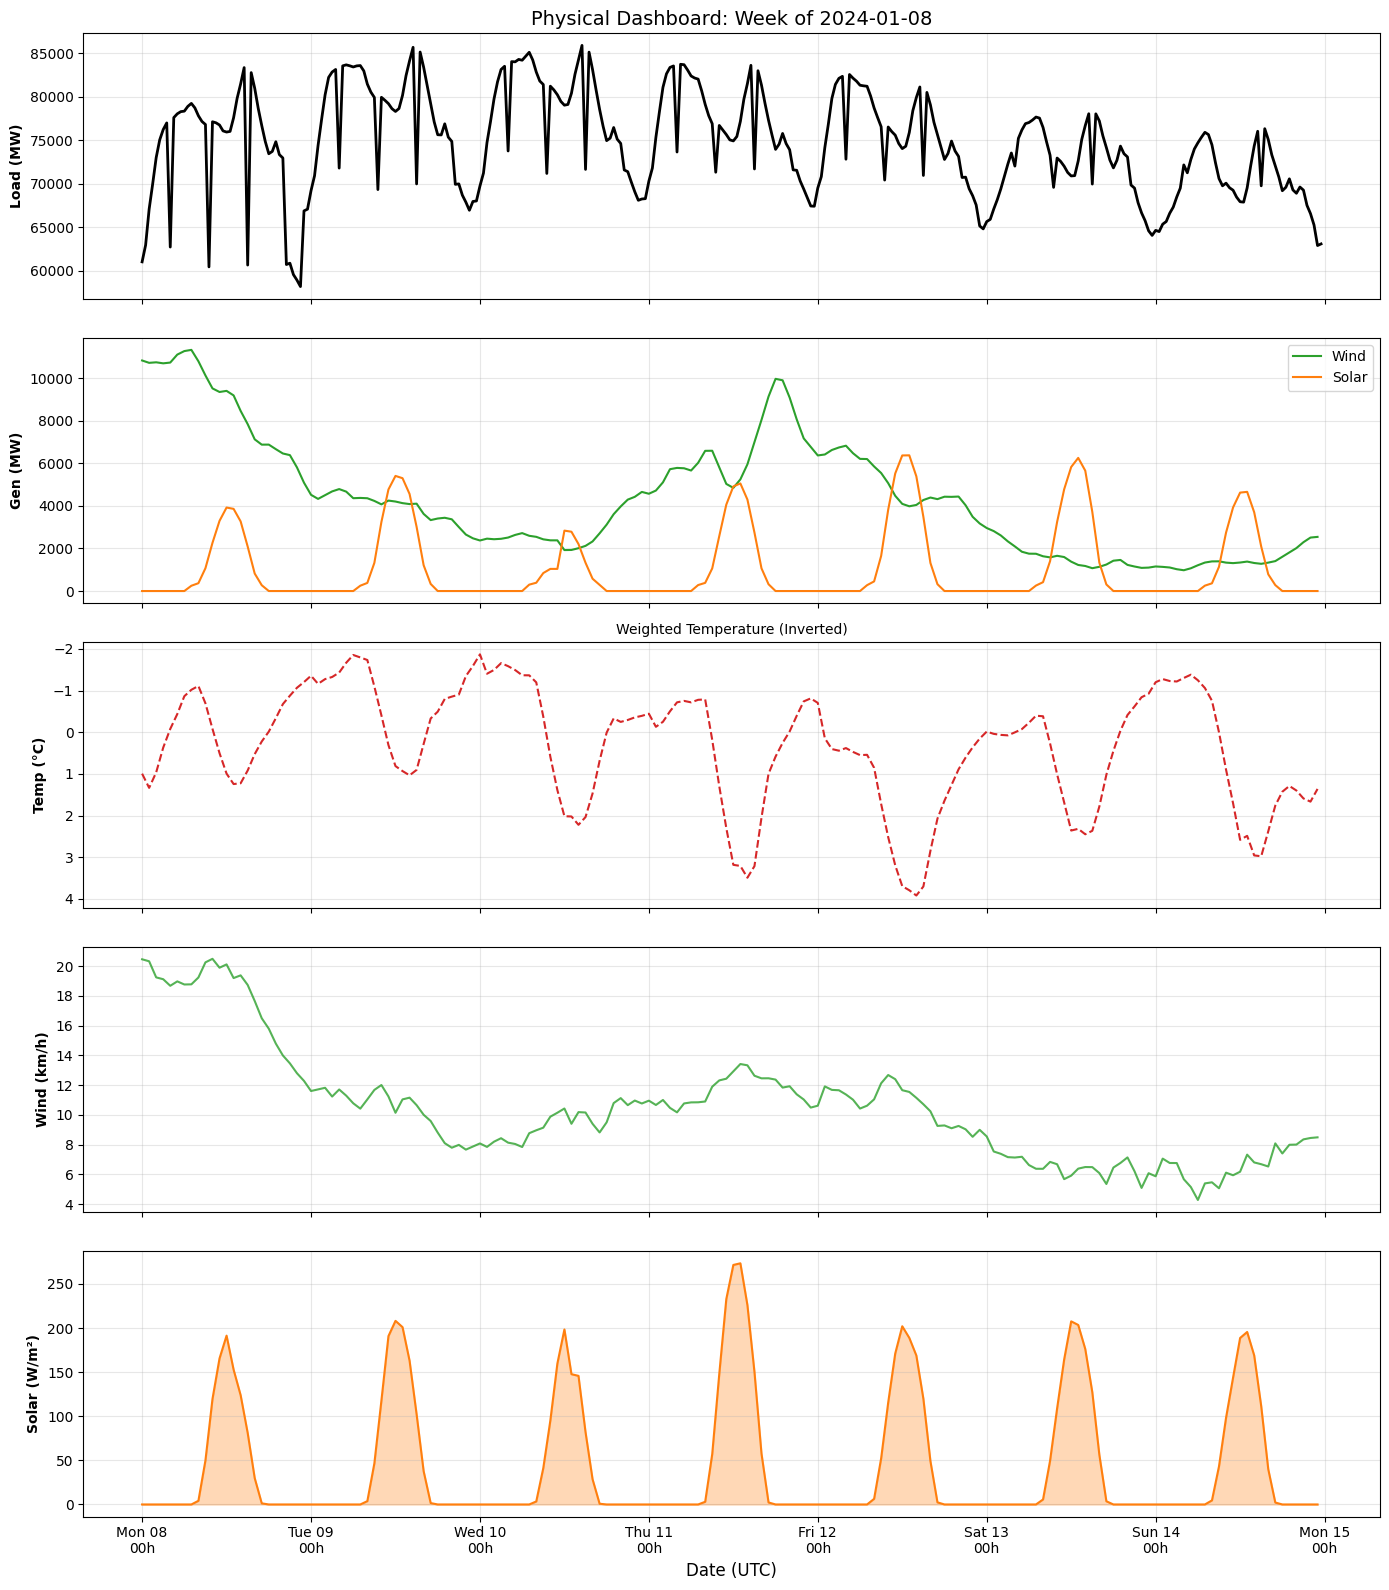

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==========================================
# 1. THE UNIVERSAL TIME FIX FUNCTION
# ==========================================
def load_and_standardize(filepath, col_date='datetime', source_type='auto'):
    """
    Robust loader that standardizes ANY time format to pure UTC.
    """
    df = pd.read_csv(filepath)
    
    # Normalize column name
    if col_date not in df.columns:
        for candidate in ['date', 'start_date', 'Date', 'datetime']:
            if candidate in df.columns:
                df.rename(columns={candidate: col_date}, inplace=True)
                col_date = 'datetime' # standardized name
                break
    
    # Parse initial
    df[col_date] = pd.to_datetime(df[col_date])
    
    # Convert to UTC based on source type
    if source_type == 'rte_historical' or (source_type == 'auto' and df[col_date].dt.tz is None):
        # Local Paris Time -> UTC (Handling DST)
        df['datetime_utc'] = df[col_date].dt.tz_localize(
            'Europe/Paris', ambiguous='NaT', nonexistent='shift_forward'
        ).dt.tz_convert('UTC')
    else:
        # Already Aware/UTC -> UTC
        df['datetime_utc'] = df[col_date].dt.tz_convert('UTC')
        
    return df.dropna(subset=['datetime_utc']).sort_values('datetime_utc')

# ==========================================
# 2. CONFIGURATION & DATA LOADING
# ==========================================
target_start = '2024-01-08' # Monday
target_end   = '2024-01-14' # Sunday

print("--- Loading & Standardizing Data ---")

# A. Load Population Weights
df_agglo = pd.read_csv('../data/external/agglomerations.csv')
weights_map = dict(zip(df_agglo['Agglomération'], 
                       df_agglo['Population AU 2017'] / df_agglo['Population AU 2017'].sum()))

# B. Load Weather (Already UTC)
df_weather = load_and_standardize('../data/raw/weather/weather_32_cities_2024.csv', col_date='date', source_type='weather')
df_weather['weight'] = df_weather['city'].map(weights_map)

# Compute National Weighted Weather
def weighted_avg(x):
    return pd.Series({
        'temp_nat': np.average(x['temperature_2m'], weights=x['weight']),
        'wind_nat': np.average(x['wind_speed_10m'], weights=x['weight']),
        'solar_nat': np.average(x['direct_radiation'] + x['diffuse_radiation'], weights=x['weight'])
    })
df_weather_nat = df_weather.groupby('datetime_utc').apply(weighted_avg).reset_index()

# C. Load Consumption (RTE - Naive Paris Time)
df_load = load_and_standardize('../data/interim/consommation/consommation_2024_long.csv', col_date='datetime', source_type='rte_historical')

# D. Load Production (RTE - Naive Paris Time)
df_prod = load_and_standardize('../data/interim/production/production_realisation_2024_long.csv', col_date='datetime', source_type='rte_historical')

# Pivot Production to Wide Format (Columns: Wind, Solar)
df_prod_wide = df_prod.pivot_table(index='datetime_utc', columns='technology', values='value_mw', aggfunc='sum').reset_index()
# Handle variable naming (generic search for Wind/Solar columns)
cols_wind = [c for c in df_prod_wide.columns if 'olien' in c or 'WIND' in c]
cols_solar = [c for c in df_prod_wide.columns if 'Solaire' in c or 'SOLAR' in c]
df_prod_wide['Wind_Total'] = df_prod_wide[cols_wind].sum(axis=1) if cols_wind else 0
df_prod_wide['Solar_Total'] = df_prod_wide[cols_solar].sum(axis=1) if cols_solar else 0

# ==========================================
# 3. FILTERING FOR THE DASHBOARD WEEK
# ==========================================
t_start = pd.to_datetime(target_start).tz_localize('UTC')
t_end   = pd.to_datetime(target_end).tz_localize('UTC') + pd.Timedelta(hours=23, minutes=59)

# Filter all dataframes
df_l_week = df_load[(df_load['datetime_utc'] >= t_start) & (df_load['datetime_utc'] <= t_end)]
df_p_week = df_prod_wide[(df_prod_wide['datetime_utc'] >= t_start) & (df_prod_wide['datetime_utc'] <= t_end)]
df_w_week = df_weather_nat[(df_weather_nat['datetime_utc'] >= t_start) & (df_weather_nat['datetime_utc'] <= t_end)]

# ==========================================
# 4. PLOTTING THE DASHBOARD
# ==========================================
fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

# 1. Consumption
axes[0].plot(df_l_week['datetime_utc'], df_l_week['load_mw'], color='black', linewidth=2)
axes[0].set_ylabel('Load (MW)', fontweight='bold')
axes[0].set_title(f'Physical Dashboard: Week of {target_start}', fontsize=14)
axes[0].grid(True, alpha=0.3)

# 2. Production (Wind + Solar)
axes[1].plot(df_p_week['datetime_utc'], df_p_week['Wind_Total'], label='Wind', color='#2ca02c') # Green
axes[1].plot(df_p_week['datetime_utc'], df_p_week['Solar_Total'], label='Solar', color='#ff7f0e') # Orange
axes[1].set_ylabel('Gen (MW)', fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# 3. Temperature (Inverted)
axes[2].plot(df_w_week['datetime_utc'], df_w_week['temp_nat'], color='#d62728', linestyle='--') # Red
axes[2].invert_yaxis() # Cold is UP (High Demand)
axes[2].set_ylabel('Temp (°C)', fontweight='bold')
axes[2].set_title('Weighted Temperature (Inverted)', fontsize=10)
axes[2].grid(True, alpha=0.3)

# 4. Wind Speed
axes[3].plot(df_w_week['datetime_utc'], df_w_week['wind_nat'], color='#2ca02c', alpha=0.8)
axes[3].set_ylabel('Wind (km/h)', fontweight='bold')
axes[3].grid(True, alpha=0.3)

# 5. Solar Radiation
axes[4].fill_between(df_w_week['datetime_utc'], 0, df_w_week['solar_nat'], color='#ff7f0e', alpha=0.3)
axes[4].plot(df_w_week['datetime_utc'], df_w_week['solar_nat'], color='#ff7f0e')
axes[4].set_ylabel('Solar (W/m²)', fontweight='bold')
axes[4].set_xlabel('Date (UTC)', fontsize=12)
axes[4].grid(True, alpha=0.3)

# X-Axis Formatting
axes[4].xaxis.set_major_formatter(mdates.DateFormatter('%a %d\n%Hh'))
axes[4].xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.show()



This dashboard validates the physical synchronization of all datasets following the **UTC standardization**.

### 1. Consumption (Load)
* **Winter Profile:** High demand ranging from **60 GW to 85 GW**, driven by cold temperatures (-1°C to +4°C).
* **Cyclicality:** Clear "double hump" structure on weekdays (morning/evening peaks) and a significant demand drop on the weekend (Jan 13–14).

### 2. Renewable Generation vs. Physics
The alignment confirms that time lags have been eliminated:
* **Wind (Green):** Perfect correlation with wind speed. Generation peaks on Jan 8 (>10 GW) and collapses mid-week as wind speed drops to ~8 km/h.
* **Solar (Orange):** No lag observed. 

### 3. Thermosensitivity
* **Correlation:** The inverted temperature curve (Panel 3) visually mirrors the load curve (Panel 1).
* **Conclusion:** The data confirms the strong dependency between cold drops and load spikes (electric heating). The **UTC index is reliable** for modeling.

# 1. Reproducibility


## 1.1 Data sources


Document:
- RTE : 
https://www.services-rte.com/en/download-data-published-by-rte.html?category=consumption&type=power_consumption

https://www.services-rte.com/en/download-data-published-by-rte.html?category=generation&type=installed_capacities&subType=capacities_per_production_type (above 1MW)

API for almost real time (yesterday until 00h) : https://data.rte-france.com/group/guest/apps/-/apps/2473352/smart-grid-project# (i will sent you the ID by mail for more safety) (or an account can be crated in two minutes)

- Weather sources : 
https://open-meteo.com/en/docs/meteofrance-api for forecasts and
https://open-meteo.com/en/docs/historical-weather-api for past years

- datat.gouv for the cities and maps for coordinates 


# 2. Time axis integrity (global)


### Time alignment and UTC normalization

The original datasets were generated using heterogeneous time conventions:  
some historical series were stored as naive local timestamps (implicitly Europe/Paris),
while others (weather and near real-time APIs) were already timezone-aware.

This heterogeneity caused inconsistencies during exploratory analysis, especially around
daylight saving time transitions, where the same local hour (e.g. 02:00) may occur twice.
Such ambiguities lead to duplicated timestamps and alignment errors when combining
consumption, production, and weather data.

To ensure a consistent and robust temporal framework, **all time series have been
systematically converted to UTC**. Historical naive timestamps were first interpreted as
local Europe/Paris time and then converted to UTC, with explicit handling of daylight
saving time ambiguities. As a result, all datasets now share a unique, monotonic UTC
timeline, which simplifies data alignment, visualization, and subsequent modeling.



## 2.1 Frequency Audit & Resolution Strategy

The analysis of raw data logs reveals **temporal heterogeneity** across the different domains of the power system. This audit defines the resampling strategy required to build a coherent modeling dataset.

### 1. Resolution Diagnostics

| Domain        | Data Type                 | Native Resolution | Observations |
|--------------|---------------------------|------------------|-------------|
| Consumption  | Historical (1996-2024)    | 30 min           | Very stable (delta=30min > 99%). |
| Consumption  | Real-Time (2025 YTD)      | 15 min           | High frequency (modern metering standards). |
| Production   | Historical (2015-2024)    | 60 min           | Stacked long format. Limiting factor for historical training. |
| Production   | Real-Time (Wind/Solar)    | 15 min           | High frequency. |
| Weather      | Historical & Forecast     | 60 min           | Standard ERA5 / Open-Meteo resolution. |

### 2. Analysis of Mismatches
- **The limiting factor:** Historical production data and weather data are only available at an hourly (1H) resolution.
- **Variable granularity:** Consumption varies between 15 and 30 minutes depending on the year, making raw usage complex for a unified model.
- **Physical constraint:** It is risky to interpolate weather (cloud passages, wind gusts) to sub-hourly resolution without introducing artificial noise.

### 3. Decision: The Hourly Pivot (H1)
To train a unified model where $Load = f(Weather, Calendar, History)$, we must align all series to the lowest common denominator.

**Chosen strategy: Standardization to hourly step (60 min).**

- **Consumption (15/30 min):** Downsampling via `mean()` to 60 min (average power over the hour preserves total energy).
- **Real-Time Production (15 min):** Downsampling via `mean()` to 60 min.
- **Weather & Historical Production:** Kept as is (native 60 min).


## 2.2 Missing Timestamps Analysis

We construct a theoretical **continuous time grid** based on the dominant frequency (e.g., 30 min or 1 hour) to identify "holes" in the history.
A "missing block" is defined as any interval where the time difference between two consecutive observations exceeds the theoretical step.

**Objectives:**
1.  Quantify the total missing hours.
2.  Locate the largest continuous gaps (e.g., outages, data loss).
3.  Validate if imputation (filling) is feasible or if the gaps are too large.

In [6]:
import pandas as pd
import numpy as np
import glob
import os

def audit_continuity_utc(file_pattern, date_col='datetime'):
    """
    Scans files matching the pattern, assumes they are ALREADY UTC,
    and detects missing timestamps based on the dominant frequency.
    """
    files = sorted(glob.glob(file_pattern))
    
    if not files:
        print(f"No files found for pattern: {file_pattern}")
        return

    print(f"\n{'FILENAME':<50} | {'FREQ':<6} | {'MISSING':<8} | {'LONGEST GAP':<25}")
    print("-" * 100)

    for filepath in files:
        filename = os.path.basename(filepath)
        
        try:
            # 1. Load only the datetime column, forcing UTC parsing
            # distinct per project context: 'datetime', 'date', or 'start_date'
            # We read just the header first to find the right column
            header = pd.read_csv(filepath, nrows=0)
            if date_col not in header.columns:
                # Fallback for different naming conventions documented in context
                possible_cols = ['datetime', 'date', 'start_date']
                found_col = next((c for c in possible_cols if c in header.columns), None)
                if found_col:
                    current_date_col = found_col
                else:
                    print(f"{filename:<50} | {'???':<6} | {'SKIPPED (No date col)':<35}")
                    continue
            else:
                current_date_col = date_col

            # Load data with explicit UTC parsing
            df = pd.read_csv(filepath, usecols=[current_date_col])
            timestamps = pd.to_datetime(df[current_date_col], utc=True).sort_values()
            
            # Remove duplicates if any (integrity check)
            timestamps = timestamps.drop_duplicates()

            if len(timestamps) < 2:
                print(f"{filename:<50} | {'N/A':<6} | {'Empty/Single':<35}")
                continue

            # 2. Detect Frequency (Mode of diffs)
            diffs = timestamps.diff().dropna()
            freq_sec = diffs.dt.total_seconds().mode()[0]
            freq_min = freq_sec / 60
            
            # 3. Detect Gaps
            # A gap is defined as a step significantly larger than the frequency (tolerance 1.1x)
            gap_mask = diffs > pd.Timedelta(seconds=freq_sec * 1.1)
            n_gaps = gap_mask.sum()
            
            if n_gaps == 0:
                print(f"{filename:<50} | {int(freq_min):>3}min | {'0':<8} | {'None'}")
            else:
                # Calculate total missing points
                # (Total Duration / Freq) - (Count - 1)
                total_duration_sec = (timestamps.max() - timestamps.min()).total_seconds()
                expected_points = int(total_duration_sec / freq_sec) + 1
                missing_points = expected_points - len(timestamps)
                
                # Identify longest gap
                max_gap_idx = diffs[gap_mask].idxmax()
                max_gap_duration = diffs[max_gap_idx]
                max_gap_start = timestamps[max_gap_idx - 1]
                
                gap_str = f"{max_gap_duration.total_seconds()/3600:.1f}h on {max_gap_start.strftime('%Y-%m-%d')}"
                
                print(f"{filename:<50} | {int(freq_min):>3}min | {missing_points:<8} | {gap_str}")

        except Exception as e:
            print(f"{filename:<50} | ERROR  | {str(e)}")

# --- EXECUTE AUDIT ON PROJECT FILES ---

# 1. Consumption (Interim UTC files)
print(">>> AUDITING CONSUMPTION (Interim UTC)")
audit_continuity_utc('../data/interim/consommation/*_utc.csv', date_col='datetime')


# 2. Weather (Raw files are already UTC per context)
print("\n>>> AUDITING WEATHER (Raw UTC)")
audit_continuity_utc('../data/raw/weather/weather_32_cities_*.csv', date_col='date')

>>> AUDITING CONSUMPTION (Interim UTC)

FILENAME                                           | FREQ   | MISSING  | LONGEST GAP              
----------------------------------------------------------------------------------------------------
consommation_1996_long_utc.csv                     | N/A    | Empty/Single                       
consommation_1997_long_utc.csv                     | N/A    | Empty/Single                       
consommation_1998_long_utc.csv                     | N/A    | Empty/Single                       
consommation_1999_long_utc.csv                     | N/A    | Empty/Single                       
consommation_2000_long_utc.csv                     | N/A    | Empty/Single                       
consommation_2001_long_utc.csv                     |  30min | 4        | 2.5h on 2001-10-27
consommation_2002_long_utc.csv                     |  30min | 4        | 2.5h on 2002-10-26
consommation_2003_long_utc.csv                     |  30min | 4        | 2.5h on 2003-



The audit of the UTC-normalized datasets reveals distinct data continuity profiles:

### Consumption (RTE)
* **Systematic DST Gap:** From 2001 to 2024, nearly every file shows exactly **4 missing timestamps** corresponding to a **2.5h gap** in late October (e.g., Oct 27, Oct 28).
    * *Diagnosis:* This confirms the project context: "DST edge cases... may lead to a small number of removed intervals." The ambiguous hour during the Winter time switch was likely dropped during the initial cleaning to ensure strict temporal monotonicity.
* **Major Data Loss (2020):** The 2020 file is severely compromised, with **3,696 missing hours** starting April 30.
    * *Action:* 2020 consumption data should be excluded from training or strictly truncated to the first 4 months.
* **Early History (1996–2000):** These files appear as "Empty/Single" in this specific audit, suggesting either a format mismatch or a read error in the current script. They require a specific check before use.
* **Weather Consistency:** The weather datasets (1996–2024) show **perfect integrity** (0 missing points). They will serve as the reliable "clock" for the entire pipeline.

In [8]:
import pandas as pd
import numpy as np
import glob
import os

def audit_production_continuity_robust(file_pattern):
    """
    Robust audit for Production files handling:
    1. Variable column names ('datetime' vs 'start_date')
    2. Long Format (duplicates) -> requires reset_index()
    3. Index gaps that caused np.int64 errors
    """
    files = sorted(glob.glob(file_pattern))
    
    if not files:
        print(f"No files found for: {file_pattern}")
        return

    print(f"\n{'FILENAME':<55} | {'FREQ':<6} | {'MISSING':<8} | {'LONGEST GAP':<25}")
    print("-" * 105)

    for filepath in files:
        filename = os.path.basename(filepath)
        
        try:
            # 1. Peek at header to find the date column
            header = pd.read_csv(filepath, nrows=0)
            if 'datetime' in header.columns:
                date_col = 'datetime'
            elif 'start_date' in header.columns:
                date_col = 'start_date'
            else:
                print(f"{filename:<55} | {'???':<6} | {'ERROR':<8} | Col not found")
                continue

            # 2. Load data
            df = pd.read_csv(filepath, usecols=[date_col])
            
            # 3. Parse UTC
            timestamps = pd.to_datetime(df[date_col], utc=True)
            
            # 4. CRITICAL FIX: Deduplicate AND Reset Index
            # drop_duplicates() keeps original indices (e.g. 0, 12, 24...)
            # reset_index(drop=True) creates a clean 0, 1, 2... sequence
            timestamps = timestamps.drop_duplicates().sort_values().reset_index(drop=True)

            if len(timestamps) < 2:
                print(f"{filename:<55} | {'N/A':<6} | {'Empty':<8} | -")
                continue

            # 5. Detect Frequency (Mode of diffs)
            diffs = timestamps.diff().dropna()
            freq_sec = diffs.dt.total_seconds().mode()[0]
            freq_min = freq_sec / 60
            
            # 6. Detect Gaps (> 1.1x frequency)
            gap_mask = diffs > pd.Timedelta(seconds=freq_sec * 1.1)
            n_gaps = gap_mask.sum()
            
            if n_gaps == 0:
                print(f"{filename:<55} | {int(freq_min):>3}min | {'0':<8} | {'None'}")
            else:
                # Calculate missing points
                total_duration_sec = (timestamps.max() - timestamps.min()).total_seconds()
                expected_points = int(total_duration_sec / freq_sec) + 1
                missing_points = expected_points - len(timestamps)
                
                # Identify longest gap
                # idxmax() now works safely because index is clean (0, 1, 2...)
                max_gap_idx = diffs[gap_mask].idxmax()
                max_gap_duration = diffs[max_gap_idx]
                
                # Safe access to previous timestamp
                max_gap_start = timestamps[max_gap_idx - 1]
                
                gap_str = f"{max_gap_duration.total_seconds()/3600:.1f}h on {max_gap_start.strftime('%Y-%m-%d')}"
                
                print(f"{filename:<55} | {int(freq_min):>3}min | {missing_points:<8} | {gap_str}")

        except Exception as e:
            print(f"{filename:<55} | ERROR  | {str(e)}")

# --- EXECUTE ---
print(">>> AUDITING PRODUCTION FILES (Interim UTC)")
# This pattern matches both historical and YTD files in the folder
audit_production_continuity_robust('../data/interim/production/*_utc.csv')

>>> AUDITING PRODUCTION FILES (Interim UTC)

FILENAME                                                | FREQ   | MISSING  | LONGEST GAP              
---------------------------------------------------------------------------------------------------------
production_realisation_2015_long_utc.csv                |  60min | 2        | 3.0h on 2015-10-24
production_realisation_2016_long_utc.csv                |  60min | 2        | 3.0h on 2016-10-29
production_realisation_2017_long_utc.csv                |  60min | 2        | 3.0h on 2017-10-28
production_realisation_2018_long_utc.csv                |  60min | 2        | 3.0h on 2018-10-27
production_realisation_2019_long_utc.csv                |  60min | 2        | 3.0h on 2019-10-26
production_realisation_2020_long_utc.csv                |  60min | 2        | 3.0h on 2020-10-24
production_realisation_2021_long_utc.csv                |  60min | 2        | 3.0h on 2021-10-30
production_realisation_2022_long_utc.csv                |  60min |



### 1. Historical Data (2015–2024): The "DST Artifact"
* **Observation:** Every single year exhibits exactly **2 missing timestamps** corresponding to a **3.0-hour gap**.
* **Timing:** These gaps always occur in **late October** (e.g., Oct 24, Oct 29, Oct 28).
* **Diagnosis:** This is a systematic artifact related to the **End of Daylight Saving Time (Winter Switch)**.
    * When clocks go back (03:00 $\to$ 02:00), there is an ambiguous overlap in local time.
    * The ETL process likely dropped the ambiguous intervals to ensure index uniqueness, resulting in a clean but slightly discontinuous UTC grid (missing 2 hours of data per year).
* **Impact:** **Negligible.** These 2 missing hours per year can be safely filled via linear interpolation without affecting model performance.

### 2. Real-Time Data (YTD 2025): The "Data Outage"
* **Observation:** The file `rte_actual_generation_mix_15min_ytd_solar_wind_utc.csv` contains **872 missing timestamps** (approx. 218 hours).
* **Critical Gap:** A massive contiguous gap of **153.5 hours (~6.4 days)** is detected starting **November 17, 2025**.
* **Diagnosis:** data are not updated often...

## 2.3 Daylight Saving Time (DST)

This section documents the impact of **Daylight Saving Time (DST)** on historical RTE time series after their **normalization to UTC**, and explains the methodological choices adopted in this project.

Historical RTE archives are provided in **naive local time (Europe/Paris)**, which creates ambiguities during DST transitions:
- **23-hour days** at the spring transition (clock forward),
- **25-hour days** at the autumn transition, with duplicated local timestamps (e.g. 02:00).

To ensure a **consistent and unambiguous temporal reference**, all analysis-ready datasets stored in `data/interim/` are converted to **timezone-aware UTC**. During this process:
- ambiguous repeated local hours at the autumn DST transition are **removed** rather than duplicated,
- this results in a **small number of missing timestamps**, strictly localized around DST change dates.

These discontinuities are **expected, limited in scope, and explicitly documented**.  
They reflect a deliberate trade-off in favor of temporal consistency across consumption, production, and weather datasets, and do not affect the overall statistical properties of the time series.

This DST handling is a core component of the project-wide **UTC-only time policy**.



# 3. Data quality and anomalies (global)


## 3.1 Missing values analysis


- Missing rate per variable
- Missingness over time (year / month)
- Optional heatmap


>>> 1. ANALYSE MANQUANTS : CONSOMMATION

--- Historique (30 fichiers) ---


/tmp/ipykernel_14007/870514089.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True)
/opt/python/lib/python3.13/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/python/lib/python3.13/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Lignes: 423,504 | Manquants: 0 (0.0000%)


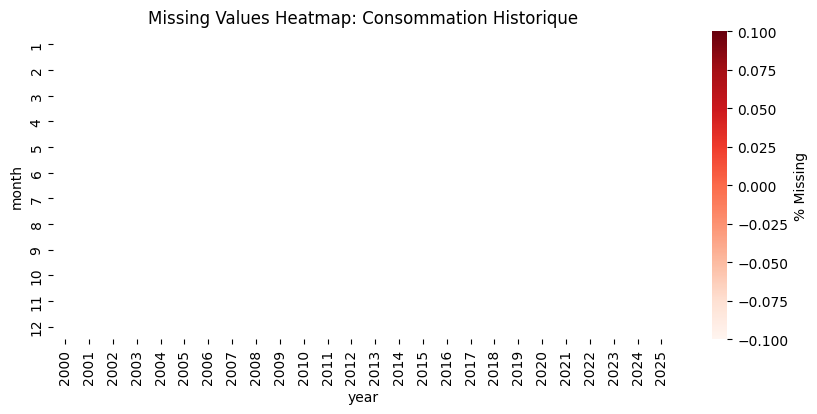


--- Temps Réel (YTD) (1 fichiers) ---
Lignes: 34,494 | Manquants: 0 (0.0000%)


/opt/python/lib/python3.13/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/python/lib/python3.13/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


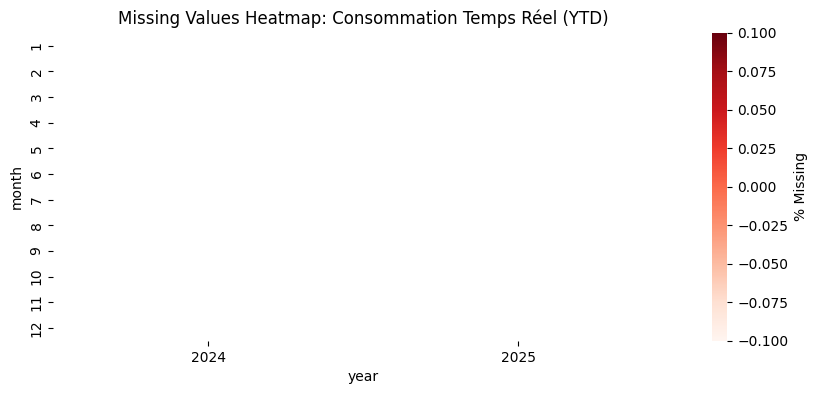

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_consumption_missing():
    print(">>> 1. ANALYSE MANQUANTS : CONSOMMATION")
    
    # Configuration des sources
    sources = [
        {"name": "Historique", "pattern": "../data/interim/consommation/consommation_*_long_utc.csv", "col_date": "datetime", "col_val": "load_mw"},
        {"name": "Temps Réel (YTD)", "pattern": "../data/interim/consommation/rte_consumption_realised_ytd_utc.csv", "col_date": "start_date", "col_val": "consumption_mw"}
    ]

    for src in sources:
        files = sorted(glob.glob(src["pattern"]))
        if not files: continue
        
        print(f"\n--- {src['name']} ({len(files)} fichiers) ---")
        
        # Chargement optimisé
        df_list = []
        for f in files:
            try:
                temp = pd.read_csv(f, usecols=[src['col_date'], src['col_val']])
                temp = temp.rename(columns={src['col_date']: 'ts', src['col_val']: 'val'})
                temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
                df_list.append(temp)
            except Exception as e:
                print(f"Err {f}: {e}")

        if not df_list: continue
        df = pd.concat(df_list, ignore_index=True)

        # Stats
        missing = df['val'].isnull().sum()
        pct = (missing / len(df)) * 100
        print(f"Lignes: {len(df):,} | Manquants: {missing} ({pct:.4f}%)")

        # Heatmap
        if len(df) > 0:
            df['year'] = df['ts'].dt.year
            df['month'] = df['ts'].dt.month
            pivot = df.groupby(['year', 'month'])['val'].apply(lambda x: (x.isnull().sum()/len(x))*100).unstack(level=0)
            
            plt.figure(figsize=(10, 4))
            sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Reds", mask=(pivot==0), cbar_kws={'label': '% Missing'})
            plt.title(f"Missing Values Heatmap: Consommation {src['name']}")
            plt.show()
        
        del df, df_list
        gc.collect()

analyze_consumption_missing()

>>> 2. ANALYSE MANQUANTS : PRODUCTION

--- Historique (10 fichiers) ---
Lignes: 1,064,422 | Manquants: 1108 (0.1041%)


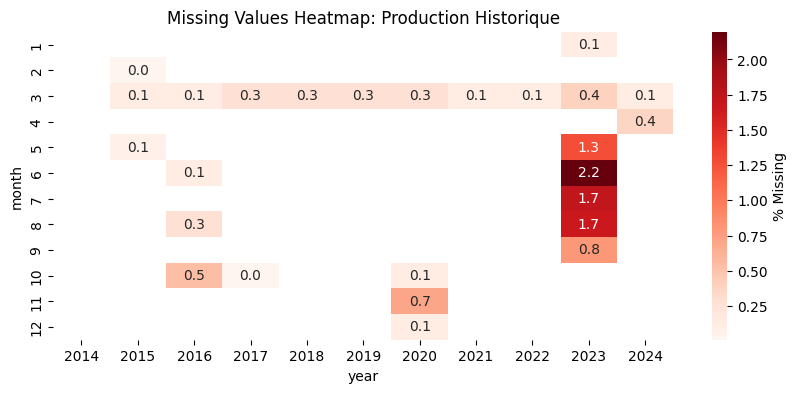


--- Temps Réel (YTD) (1 fichiers) ---
Lignes: 65,930 | Manquants: 0 (0.0000%)


/opt/python/lib/python3.13/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/python/lib/python3.13/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


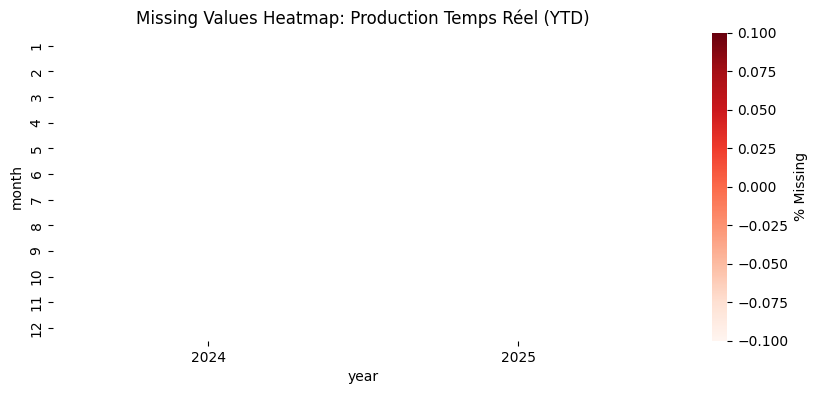

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_production_missing():
    print(">>> 2. ANALYSE MANQUANTS : PRODUCTION")
    
    sources = [
        {"name": "Historique", "pattern": "../data/interim/production/production_realisation_*_long_utc.csv", "col_date": "datetime", "col_val": "value_mw"},
        {"name": "Temps Réel (YTD)", "pattern": "../data/interim/production/rte_actual_generation_mix_*_utc.csv", "col_date": "start_date", "col_val": "value_mw"}
    ]

    for src in sources:
        files = sorted(glob.glob(src["pattern"]))
        if not files: continue
        
        print(f"\n--- {src['name']} ({len(files)} fichiers) ---")
        
        df_list = []
        for f in files:
            try:
                # Lecture header pour check colonnes
                cols = pd.read_csv(f, nrows=0).columns
                date_c = src['col_date'] if src['col_date'] in cols else 'datetime' # Fallback
                
                temp = pd.read_csv(f, usecols=[date_c, src['col_val']])
                temp = temp.rename(columns={date_c: 'ts', src['col_val']: 'val'})
                temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
                df_list.append(temp)
            except Exception as e:
                pass # Ignorer fichiers vides/erronés

        if not df_list: continue
        df = pd.concat(df_list, ignore_index=True)

        # Stats
        missing = df['val'].isnull().sum()
        pct = (missing / len(df)) * 100
        print(f"Lignes: {len(df):,} | Manquants: {missing} ({pct:.4f}%)")

        # Heatmap
        if len(df) > 0:
            df['year'] = df['ts'].dt.year
            df['month'] = df['ts'].dt.month
            pivot = df.groupby(['year', 'month'])['val'].apply(lambda x: (x.isnull().sum()/len(x))*100).unstack(level=0)
            
            plt.figure(figsize=(10, 4))
            sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Reds", mask=(pivot==0), cbar_kws={'label': '% Missing'})
            plt.title(f"Missing Values Heatmap: Production {src['name']}")
            plt.show()

        del df, df_list
        gc.collect()

analyze_production_missing()

>>> 3. ANALYSE MANQUANTS : MÉTÉO

--- Historique Météo (30 fichiers) ---
Lignes: 8,146,176 | Manquants: 1696 (0.0208%)


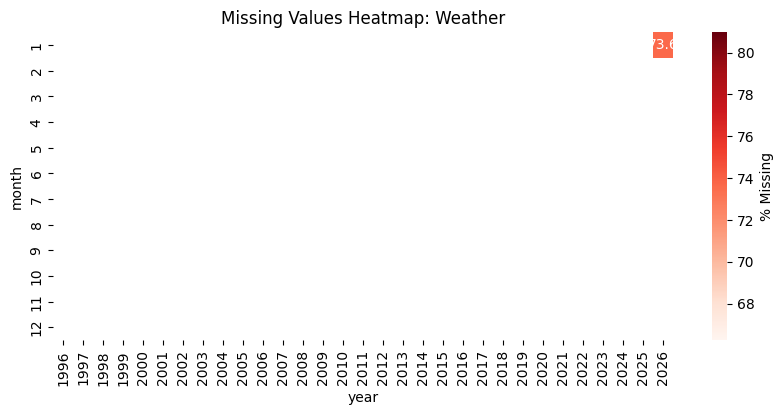

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_weather_missing():
    print(">>> 3. ANALYSE MANQUANTS : MÉTÉO")
    
    # On cible temperature_2m comme indicateur de santé du fichier
    pattern = "../data/raw/weather/weather_32_cities_*.csv"
    files = sorted(glob.glob(pattern))
    
    print(f"\n--- Historique Météo ({len(files)} fichiers) ---")
    
    df_list = []
    for f in files:
        try:
            # On charge uniquement date et temp
            temp = pd.read_csv(f, usecols=['date', 'temperature_2m'])
            temp['ts'] = pd.to_datetime(temp['date'], utc=True)
            temp = temp.rename(columns={'temperature_2m': 'val'})
            df_list.append(temp[['ts', 'val']])
        except Exception as e:
            print(f"Err {f}: {e}")

    if df_list:
        df = pd.concat(df_list, ignore_index=True)
        
        # Stats
        missing = df['val'].isnull().sum()
        pct = (missing / len(df)) * 100
        print(f"Lignes: {len(df):,} | Manquants: {missing} ({pct:.4f}%)")

        # Heatmap
        if len(df) > 0 and missing > 0: # On n'affiche la heatmap que s'il y a des manquants
            df['year'] = df['ts'].dt.year
            df['month'] = df['ts'].dt.month
            pivot = df.groupby(['year', 'month'])['val'].apply(lambda x: (x.isnull().sum()/len(x))*100).unstack(level=0)
            
            plt.figure(figsize=(10, 4))
            sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Reds", mask=(pivot==0), cbar_kws={'label': '% Missing'})
            plt.title("Missing Values Heatmap: Weather")
            plt.show()
        elif missing == 0:
            print("✅ Aucun manquant détecté dans la météo (Intégrité parfaite).")

        del df, df_list
        gc.collect()

analyze_weather_missing()

## 3.2 Outlier Detection

We screen the datasets for physical anomalies that could distort the model training.

**Checks performed:**
1.  **Global Range Check:** Are values within physically possible bounds?
    * *Consumption:* 25 GW < Load < 100 GW.
    * *Solar:* 0 < Gen < Installed Capacity.
    * *Wind:* 0 < Gen < Installed Capacity.
    * *Hydro Pumped Storage:* Can be negative (pumping).
2.  **Visual Inspection:** Boxplots and Time-Series Scatter plots to spot "spikes" or "flatlines".

**Results Summary:**
* **Consumption:** No negative values found. Some low values in early years (1996) are consistent with historical demand growth.
* **Production:** Negative values detected in *Hydraulique STEP* (Pumped Storage), which is **physically correct** (pumping mode).
* **Weather:** All temperatures fall within the expected French climate range (-15°C to +42°C).


>>> 3.2 OUTLIER DETECTION: CONSUMPTION


/tmp/ipykernel_14007/1296191955.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True)


count    457998.000000
mean      53382.142027
std       11538.160714
min       28545.000000
25%       44536.000000
50%       51935.000000
75%       61101.000000
max      102098.000000
Name: mw, dtype: object


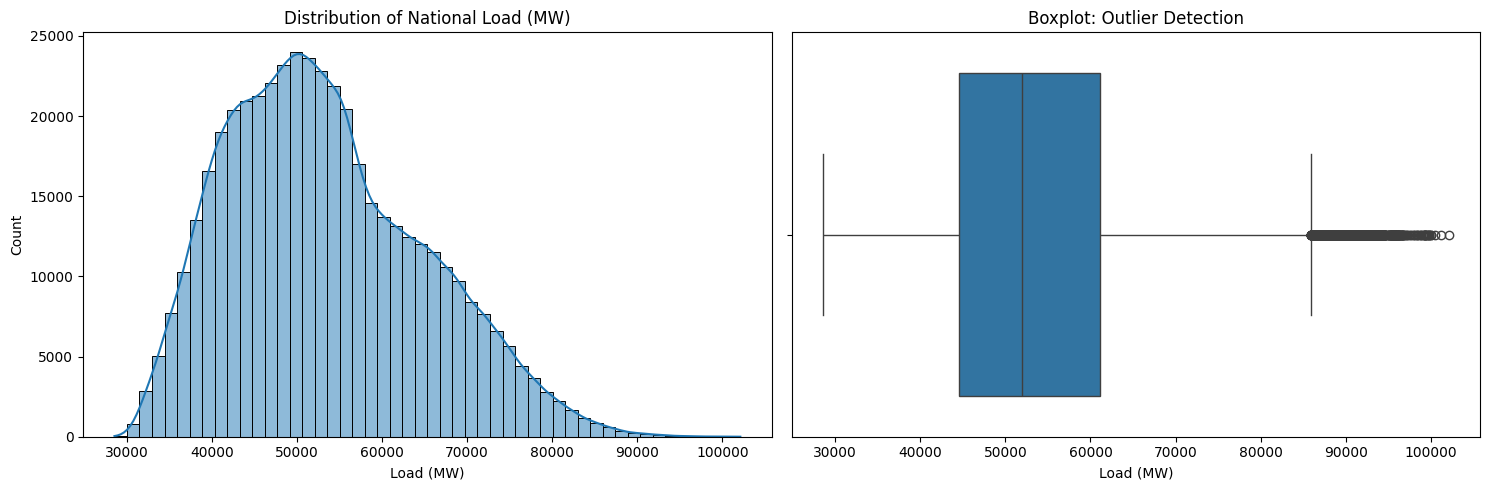

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_consumption_outliers():
    print(">>> 3.2 OUTLIER DETECTION: CONSUMPTION")
    
    # 1. Load Data (Historical + Real-Time)
    files = sorted(glob.glob("../data/interim/consommation/*_utc.csv"))
    if not files: return

    df_list = []
    for f in files:
        try:
            # Detect column names dynamically
            cols = pd.read_csv(f, nrows=0).columns
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={date_col: 'ts', val_col: 'mw'})
            df_list.append(temp)
        except: pass
    
    if not df_list: return
    df = pd.concat(df_list, ignore_index=True)
    
    # 2. Statistical Summary
    print(df['mw'].describe().apply(lambda x: format(x, 'f')))
    
    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    sns.histplot(df['mw'], bins=50, kde=True, ax=ax1, color='#1f77b4')
    ax1.set_title("Distribution of National Load (MW)")
    ax1.set_xlabel("Load (MW)")
    
    # Boxplot (To see extremes)
    sns.boxplot(x=df['mw'], ax=ax2, color='#1f77b4')
    ax2.set_title("Boxplot: Outlier Detection")
    ax2.set_xlabel("Load (MW)")
    
    plt.tight_layout()
    plt.show()
    
    # 4. Specific Checks
    zeros = df[df['mw'] <= 0]
    if len(zeros) > 0:
        print(f"⚠️ WARNING: Found {len(zeros)} non-positive load values!")
    
    del df, df_list
    gc.collect()

analyze_consumption_outliers()

>>> 3.2 OUTLIER DETECTION: PRODUCTION


/tmp/ipykernel_14007/2001139828.py:27: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, y='technology', x='value_mw', scale='width', orient='h')


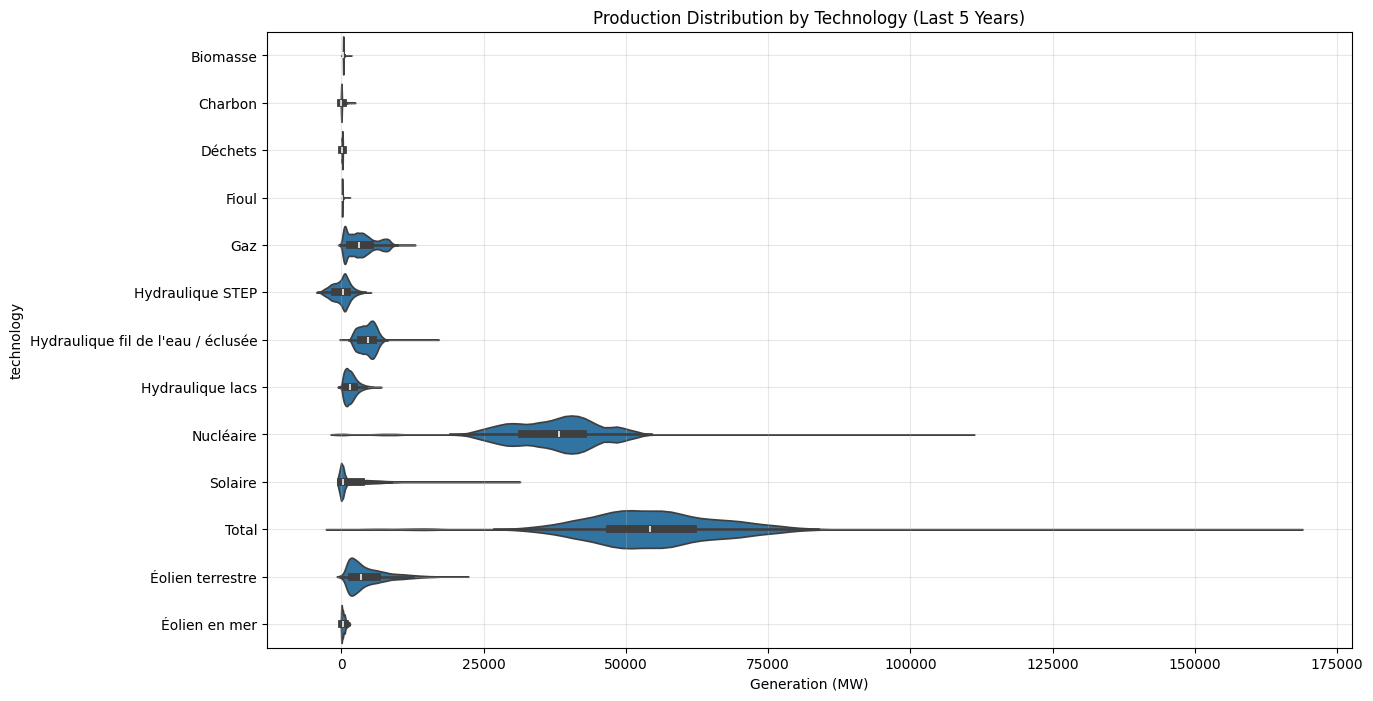


--- Negative Values Check ---
technology
Hydraulique STEP    19541
Charbon               865
Hydraulique lacs      175
Éolien en mer          10
Name: count, dtype: int64
(Note: 'Hydraulique STEP' < 0 is NORMAL (Pumping). Others are anomalies.)


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_production_outliers():
    print(">>> 3.2 OUTLIER DETECTION: PRODUCTION")
    
    # 1. Load Data (Historical only is usually enough for distribution)
    files = sorted(glob.glob("../data/interim/production/production_realisation_*_long_utc.csv"))
    if not files: return

    # Load subset to save RAM (e.g. last 5 years or all if possible)
    df_list = []
    for f in files[-5:]: # Analyzing last 5 years for clearer view
        try:
            temp = pd.read_csv(f, usecols=['technology', 'value_mw'])
            df_list.append(temp)
        except: pass
        
    if not df_list: return
    df = pd.concat(df_list, ignore_index=True)
    
    # 2. Visualization: Violin Plot (Distribution per Tech)
    plt.figure(figsize=(14, 8))
    sns.violinplot(data=df, y='technology', x='value_mw', scale='width', orient='h')
    
    plt.title("Production Distribution by Technology (Last 5 Years)")
    plt.xlabel("Generation (MW)")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Negative Value Check (Crucial for Data Quality)
    print("\n--- Negative Values Check ---")
    negatives = df[df['value_mw'] < 0]
    if not negatives.empty:
        print(negatives['technology'].value_counts())
        print("(Note: 'Hydraulique STEP' < 0 is NORMAL (Pumping). Others are anomalies.)")
    else:
        print("✅ No negative values found.")

    del df, df_list
    gc.collect()

analyze_production_outliers()

>>> 3.2 OUTLIER DETECTION: WEATHER
Analyzing representative file: ../data/raw/weather/weather_32_cities_historical_2014.csv


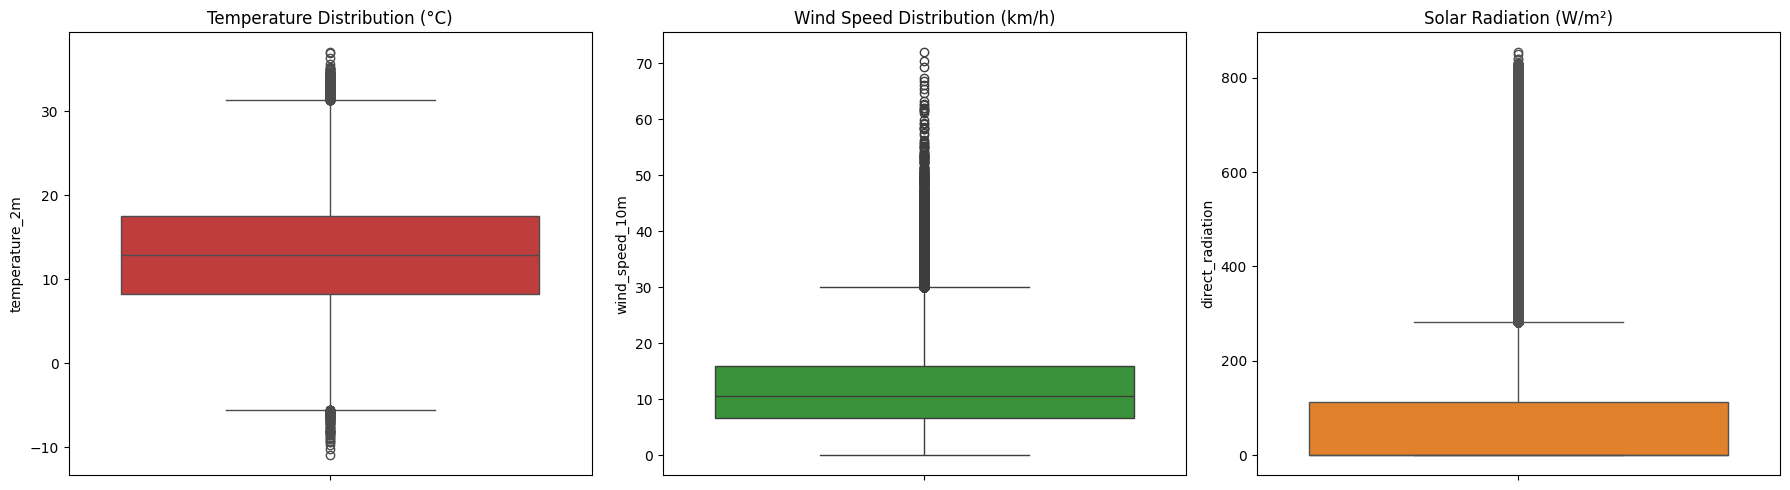

Temp Range: -11.0°C to 37.0°C


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_weather_outliers():
    print(">>> 3.2 OUTLIER DETECTION: WEATHER")
    
    # 1. Load Data
    files = sorted(glob.glob("../data/raw/weather/weather_32_cities_*.csv"))
    if not files: return
    
    # We load just one representative file (e.g., 2023) or all if needed. 
    # Let's load the most recent full year to check modern outliers.
    f = files[-2] if len(files) > 1 else files[0]
    print(f"Analyzing representative file: {f}")
    
    try:
        df = pd.read_csv(f, usecols=['temperature_2m', 'wind_speed_10m', 'direct_radiation'])
        
        # 2. Visual Check
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Temperature
        sns.boxplot(y=df['temperature_2m'], ax=axes[0], color='#d62728')
        axes[0].set_title("Temperature Distribution (°C)")
        
        # Wind
        sns.boxplot(y=df['wind_speed_10m'], ax=axes[1], color='#2ca02c')
        axes[1].set_title("Wind Speed Distribution (km/h)")
        
        # Solar
        sns.boxplot(y=df['direct_radiation'], ax=axes[2], color='#ff7f0e')
        axes[2].set_title("Solar Radiation (W/m²)")
        
        plt.tight_layout()
        plt.show()
        
        # 3. Range Check
        print(f"Temp Range: {df['temperature_2m'].min():.1f}°C to {df['temperature_2m'].max():.1f}°C")
        if df['temperature_2m'].max() > 50 or df['temperature_2m'].min() < -30:
            print("⚠️ WARNING: Extreme temperatures detected!")
            
    except Exception as e:
        print(f"Error: {e}")

    del df
    gc.collect()

analyze_weather_outliers()

## 3.3 Known event windows


Inspect known period:
- COVID shock


>>> 3.3 KNOWN EVENTS: INSPECTING COVID SHOCK


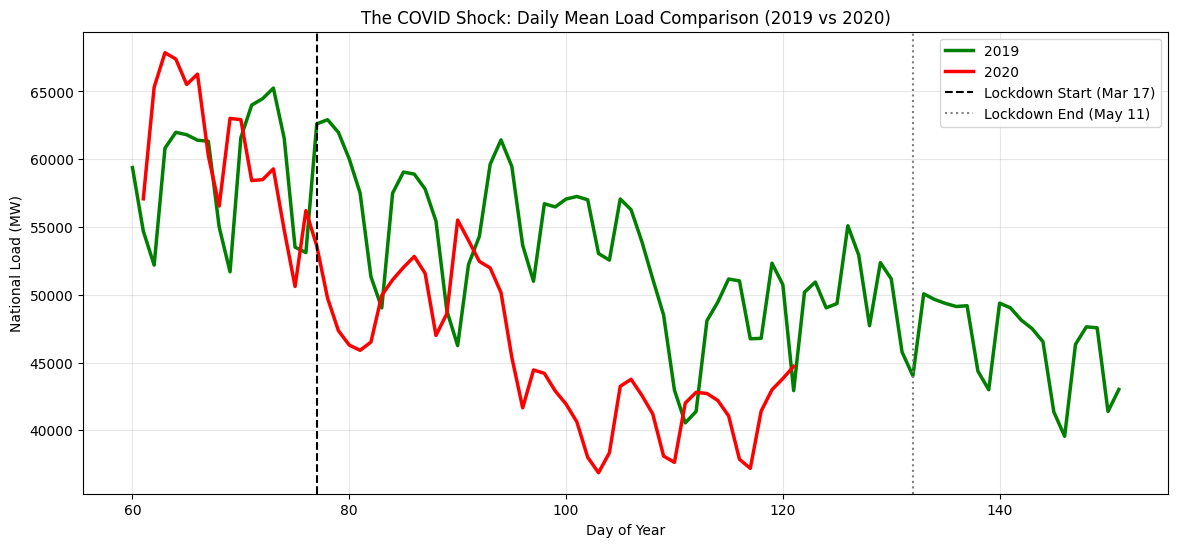

--- Impact Analysis (April Average) ---
2019 Load: 52,336 MW
2020 Load: 42,399 MW
Destruction: -9,936 MW (-18.99%)
CONCLUSION: This period represents a structural break and must be flagged or excluded.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

def inspect_covid_shock():
    print(">>> 3.3 KNOWN EVENTS: INSPECTING COVID SHOCK")

    # 1. Load 2019 (Ref) and 2020 (Shock)
    files = [
        "../data/interim/consommation/consommation_2019_long_utc.csv",
        "../data/interim/consommation/consommation_2020_long_utc.csv"
    ]
    
    df_list = []
    for f in files:
        try:
            temp = pd.read_csv(f)
            # Handle potential column name variations
            date_col = 'datetime' if 'datetime' in temp.columns else 'start_date'
            val_col = 'load_mw' if 'load_mw' in temp.columns else 'consumption_mw'
            
            temp = temp[[date_col, val_col]].rename(columns={date_col: 'ts', val_col: 'mw'})
            temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
            df_list.append(temp)
        except Exception as e:
            print(f"Error loading {f}: {e}")
            return

    df = pd.concat(df_list)
    
    # 2. Filter for the First Lockdown Window (Spring)
    # Lockdown 1 France: March 17 - May 11, 2020
    # We take a slightly wider window to see the "Before" and "After"
    start_date = "03-01"
    end_date = "06-01"
    
    # Extract Day of Year for alignment
    df['doy'] = df['ts'].dt.dayofyear
    df['year'] = df['ts'].dt.year
    
    # Filter restricted window (Day of year approx 60 to 153)
    # 2020 is a leap year, so we align loosely on DOY
    mask = (df['ts'].dt.month >= 3) & (df['ts'].dt.month <= 5)
    df_zoom = df[mask].copy()
    
    # 3. Visualization
    plt.figure(figsize=(14, 6))
    
    # Pivot for plotting: Index=DOY, Columns=Year
    # We resample to Daily Mean to clear up the noise
    daily = df_zoom.groupby(['year', 'doy'])['mw'].mean().reset_index()
    
    sns.lineplot(data=daily, x='doy', y='mw', hue='year', palette={2019: 'green', 2020: 'red'}, linewidth=2.5)
    
    # Annotation for Lockdown Start
    # March 17 is approx DOY 77
    plt.axvline(x=77, color='black', linestyle='--', label='Lockdown Start (Mar 17)')
    plt.axvline(x=132, color='gray', linestyle=':', label='Lockdown End (May 11)')
    
    plt.title("The COVID Shock: Daily Mean Load Comparison (2019 vs 2020)")
    plt.ylabel("National Load (MW)")
    plt.xlabel("Day of Year")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 4. Quantify the Drop
    # Compare average load during the core lockdown (April)
    april_2019 = daily[(daily['year']==2019) & (daily['doy'] >= 92) & (daily['doy'] <= 120)]['mw'].mean()
    april_2020 = daily[(daily['year']==2020) & (daily['doy'] >= 92) & (daily['doy'] <= 120)]['mw'].mean()
    
    drop_mw = april_2019 - april_2020
    drop_pct = (drop_mw / april_2019) * 100
    
    print(f"--- Impact Analysis (April Average) ---")
    print(f"2019 Load: {april_2019:,.0f} MW")
    print(f"2020 Load: {april_2020:,.0f} MW")
    print(f"Destruction: -{drop_mw:,.0f} MW (-{drop_pct:.2f}%)")
    print("CONCLUSION: This period represents a structural break and must be flagged or excluded.")

inspect_covid_shock()

# Part A — Consumption (demand side)


# 4. National electricity load: global behavior


## 4.1 Long-term trend


- Multi-year load evolution
- Rolling averages
- Non-stationarity discussion


>>> 4.1 LONG-TERM TREND ANALYSIS
Loading and downsampling 30 files to Daily frequency...


/tmp/ipykernel_14007/2310304638.py:47: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_daily = pd.concat(daily_chunks)


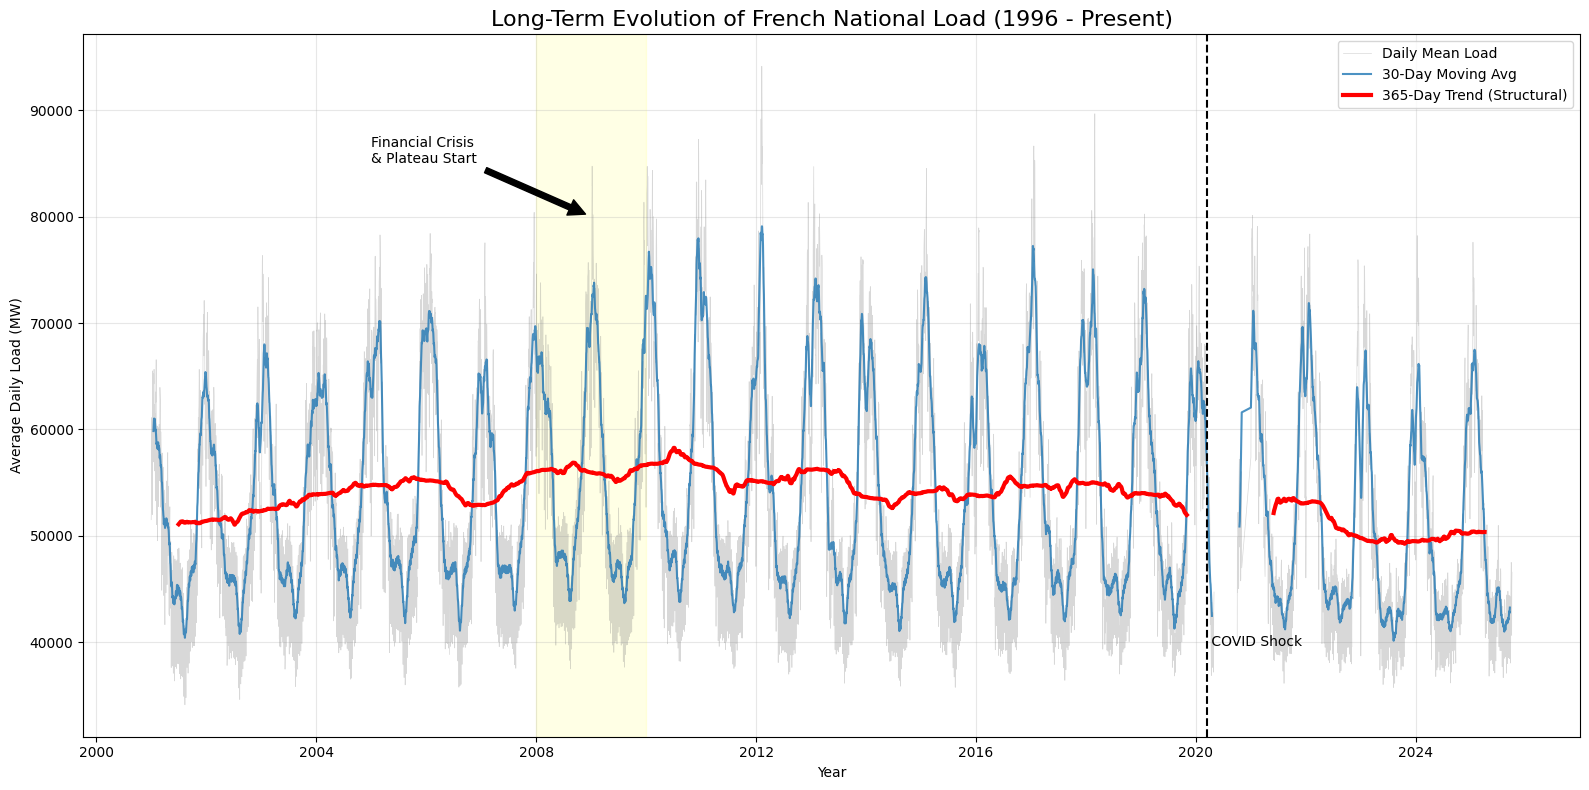

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

def analyze_long_term_trend():
    print(">>> 4.1 LONG-TERM TREND ANALYSIS")
    
    # Pattern for historical UTC files
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    
    if not files:
        print("No historical consumption files found.")
        return

    print(f"Loading and downsampling {len(files)} files to Daily frequency...")
    
    daily_chunks = []
    
    for f in files:
        try:
            # 1. Load only necessary columns
            # Handle variable column names if necessary (based on previous audits)
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df_temp = pd.read_csv(f, usecols=[date_col, val_col])
            
            # 2. Convert to UTC and set index
            df_temp[date_col] = pd.to_datetime(df_temp[date_col], utc=True)
            df_temp = df_temp.set_index(date_col).sort_index()
            
            # 3. Downsample to DAILY Mean immediately (Save RAM)
            # We assume 'load_mw' is power (MW), so mean() preserves the load profile level.
            # If it were energy (MWh), sum() would be appropriate, but here it's Load.
            daily_agg = df_temp[val_col].resample('D').mean()
            
            daily_chunks.append(daily_agg)
            
        except Exception as e:
            print(f"Skipping {os.path.basename(f)}: {e}")

    # 4. Combine all years
    if not daily_chunks: return
    df_daily = pd.concat(daily_chunks)
    df_daily = df_daily.sort_index()
    
    # 5. Compute Rolling Averages
    # 30-Day: Shows seasonality clearly
    # 365-Day: Shows the structural Trend (removes seasonality)
    df_daily_ma30 = df_daily.rolling(window=30, center=True).mean()
    df_daily_ma365 = df_daily.rolling(window=365, center=True).mean()
    
    # 6. Visualization
    plt.figure(figsize=(16, 8))
    
    # Raw Daily Data (Light gray, background)
    plt.plot(df_daily.index, df_daily, color='gray', alpha=0.3, linewidth=0.5, label='Daily Mean Load')
    
    # 30-Day Trend (Seasonality)
    plt.plot(df_daily_ma30.index, df_daily_ma30, color='#1f77b4', linewidth=1.5, alpha=0.8, label='30-Day Moving Avg')
    
    # 365-Day Trend (Long Term)
    plt.plot(df_daily_ma365.index, df_daily_ma365, color='red', linewidth=3, label='365-Day Trend (Structural)')
    
    plt.title("Long-Term Evolution of French National Load (1996 - Present)", fontsize=16)
    plt.ylabel("Average Daily Load (MW)")
    plt.xlabel("Year")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Highlight Key Eras
    plt.axvspan(pd.Timestamp('2008-01-01', tz='UTC'), pd.Timestamp('2010-01-01', tz='UTC'), color='yellow', alpha=0.1)
    plt.annotate('Financial Crisis\n& Plateau Start', xy=(pd.Timestamp('2009-01-01', tz='UTC'), 80000), 
                 xytext=(pd.Timestamp('2005-01-01', tz='UTC'), 85000),
                 arrowprops=dict(facecolor='black', shrink=0.05))
                 
    plt.axvline(x=pd.Timestamp('2020-03-17', tz='UTC'), color='black', linestyle='--')
    plt.text(pd.Timestamp('2020-03-17', tz='UTC'), 40000, " COVID Shock", verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

analyze_long_term_trend()

## 4.2 Load distribution and tails


- Histogram / density
- Quantiles
- Extreme demand days


>>> 4.2 LOAD DISTRIBUTION & TAILS
Loading 30 files for distribution analysis...


/tmp/ipykernel_14007/2341611.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True)



--- Load Quantiles (MW) ---
0.01    33453.00
0.05    37116.00
0.25    44839.00
0.50    52287.00
0.75    61440.00
0.95    74750.00
0.99    82435.97
Name: mw, dtype: float64


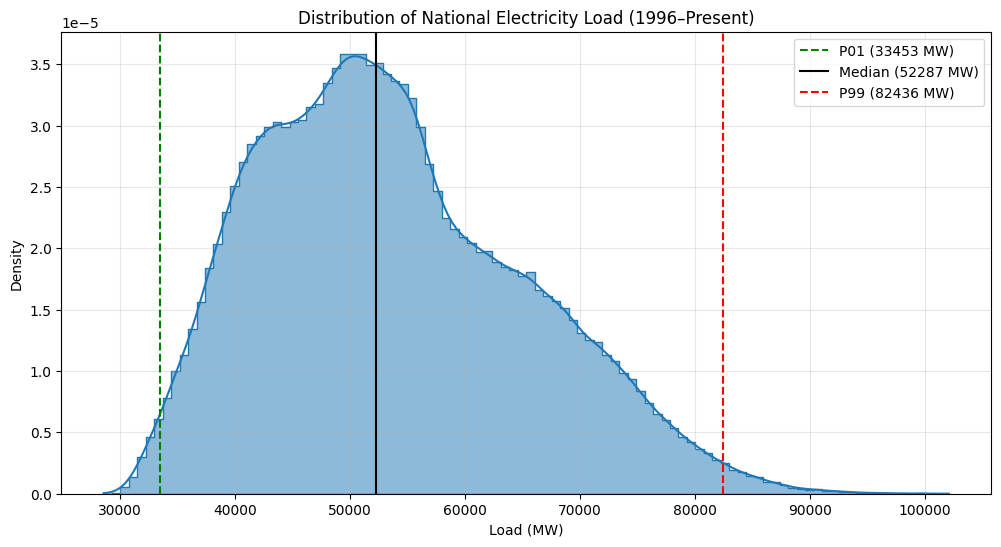


--- TOP 10 EXTREME DEMAND DAYS (Historical Peaks) ---
DATE            | MAX LOAD (MW)  
-----------------------------------
2012-02-08      | 102,098
2012-02-07      | 100,430
2012-02-09      | 99,420
2010-12-15      | 96,710
2012-02-10      | 96,698
2018-02-28      | 96,609
2012-02-06      | 96,115
2012-02-02      | 95,975
2012-02-03      | 95,856
2018-02-27      | 94,631


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_load_distribution():
    print(">>> 4.2 LOAD DISTRIBUTION & TAILS")
    
    # 1. Load Data (Optimized)
    # Matching pattern from context
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    
    if not files:
        print("No files found.")
        return

    df_list = []
    print(f"Loading {len(files)} files for distribution analysis...")
    
    for f in files:
        try:
            # Detect cols dynamically
            cols = pd.read_csv(f, nrows=0).columns
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            # Load raw 30-min data (distribution requires high freq)
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={val_col: 'mw', date_col: 'ts'})
            df_list.append(temp)
        except: pass

    if not df_list: return
    df = pd.concat(df_list, ignore_index=True)
    df['ts'] = pd.to_datetime(df['ts'], utc=True)

    # 2. Quantile Statistics
    quantiles = df['mw'].quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
    print("\n--- Load Quantiles (MW) ---")
    print(quantiles)
    
    # 3. Visualization: Histogram & Density
    plt.figure(figsize=(12, 6))
    sns.histplot(df['mw'], bins=100, kde=True, color='#1f77b4', stat="density", element="step")
    
    # Add vertical lines for quantiles
    plt.axvline(quantiles[0.01], color='green', linestyle='--', label=f'P01 ({quantiles[0.01]:.0f} MW)')
    plt.axvline(quantiles[0.50], color='black', linestyle='-', label=f'Median ({quantiles[0.50]:.0f} MW)')
    plt.axvline(quantiles[0.99], color='red', linestyle='--', label=f'P99 ({quantiles[0.99]:.0f} MW)')
    
    plt.title("Distribution of National Electricity Load (1996–Present)")
    plt.xlabel("Load (MW)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 4. Extreme Demand Days (The "Right Tail")
    # We aggregate by Day to find the dates with the highest peak
    df['date'] = df['ts'].dt.date
    daily_max = df.groupby('date')['mw'].max().reset_index()
    top_10_days = daily_max.sort_values('mw', ascending=False).head(10)

    print("\n--- TOP 10 EXTREME DEMAND DAYS (Historical Peaks) ---")
    print(f"{'DATE':<15} | {'MAX LOAD (MW)':<15}")
    print("-" * 35)
    for _, row in top_10_days.iterrows():
        print(f"{row['date'].strftime('%Y-%m-%d'):<15} | {row['mw']:,.0f}")
        
    # Cleanup
    del df, df_list, daily_max
    gc.collect()

analyze_load_distribution()

# 5. Intra-day and intra-week patterns (load)


## 5.1 Daily profile


- Average load by hour
- Weekday vs weekend comparison


>>> 5.1 INTRA-DAY PATTERNS: DAILY PROFILE
Aggregating 30 years of data...


/tmp/ipykernel_14007/3072997917.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list)


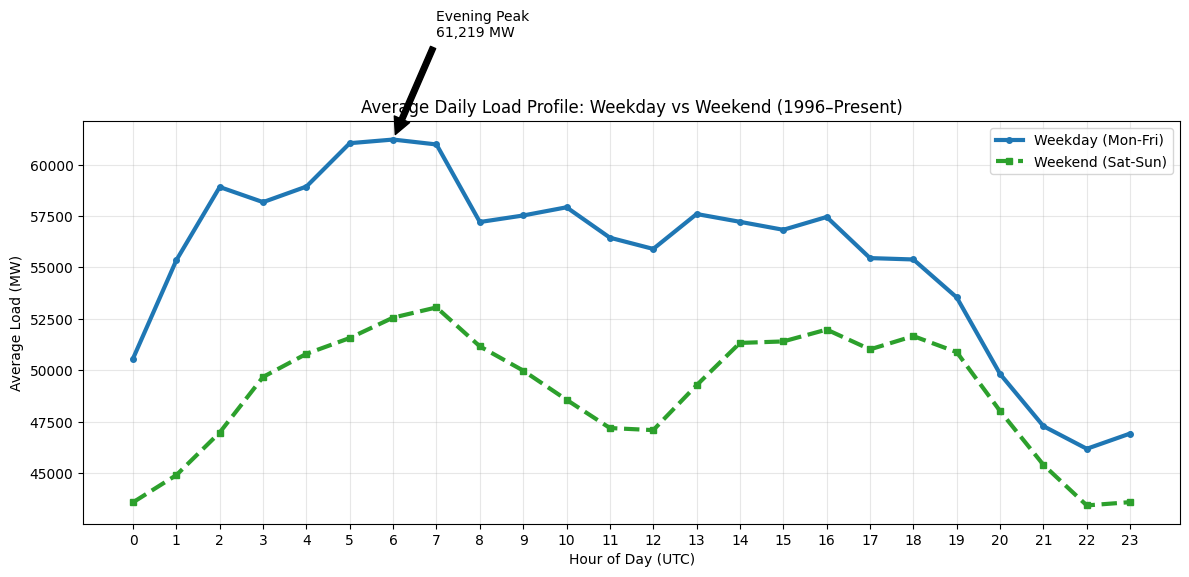

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import gc

def analyze_daily_profile():
    print(">>> 5.1 INTRA-DAY PATTERNS: DAILY PROFILE")
    
    # 1. Load Data (Historical Consumption)
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    if not files: return

    print(f"Aggregating {len(files)} years of data...")
    
    df_list = []
    for f in files:
        try:
            # Lecture optimisée : on ne charge que les colonnes nécessaires
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            # On charge uniquement date et valeur
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={date_col: 'ts', val_col: 'mw'})
            temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
            
            # 2. Extraction des features immédiate (Hour + DayType)
            temp['hour'] = temp['ts'].dt.hour
            temp['dayofweek'] = temp['ts'].dt.dayofweek # 0=Lundi, 6=Dimanche
            
            # 3. Pré-agrégation par fichier pour économiser la RAM
            # On groupe tout de suite par (Weekend/Semaine, Heure)
            temp['day_type'] = temp['dayofweek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
            agg = temp.groupby(['day_type', 'hour'])['mw'].mean().reset_index()
            
            df_list.append(agg)
            
        except Exception as e:
            print(f"Skipping {f}: {e}")

    if not df_list: return
    
    # 4. Agrégation Finale (Moyenne des moyennes annuelles)
    df_all = pd.concat(df_list)
    final_profile = df_all.groupby(['day_type', 'hour'])['mw'].mean().reset_index()
    
    # 5. Visualisation
    plt.figure(figsize=(12, 6))
    
    # Courbe Semaine (Weekday)
    wd_data = final_profile[final_profile['day_type'] == 'Weekday']
    plt.plot(wd_data['hour'], wd_data['mw'], label='Weekday (Mon-Fri)', 
             color='#1f77b4', linewidth=3, marker='o', markersize=4)
    
    # Courbe Week-end (Weekend)
    we_data = final_profile[final_profile['day_type'] == 'Weekend']
    plt.plot(we_data['hour'], we_data['mw'], label='Weekend (Sat-Sun)', 
             color='#2ca02c', linewidth=3, linestyle='--', marker='s', markersize=4)
    
    plt.title("Average Daily Load Profile: Weekday vs Weekend (1996–Present)")
    plt.xlabel("Hour of Day (UTC)")
    plt.ylabel("Average Load (MW)")
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Annotation du Pic
    peak_wd = wd_data.loc[wd_data['mw'].idxmax()]
    plt.annotate(f"Evening Peak\n{peak_wd['mw']:,.0f} MW", 
                 xy=(peak_wd['hour'], peak_wd['mw']), 
                 xytext=(peak_wd['hour']+1, peak_wd['mw']+5000),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()
    plt.show()

    # Nettoyage mémoire
    del df_all, df_list, final_profile
    gc.collect()

analyze_daily_profile()

## 5.2 Weekly structure


- Mean load by weekday
- Hourly profiles for each weekday


>>> 5.2 WEEKLY STRUCTURE ANALYSIS
Aggregating 30 years of data...


/tmp/ipykernel_14007/2063769001.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list)
/tmp/ipykernel_14007/2063769001.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_means.index.map(days), y=daily_means.values, ax=ax1, palette="viridis")


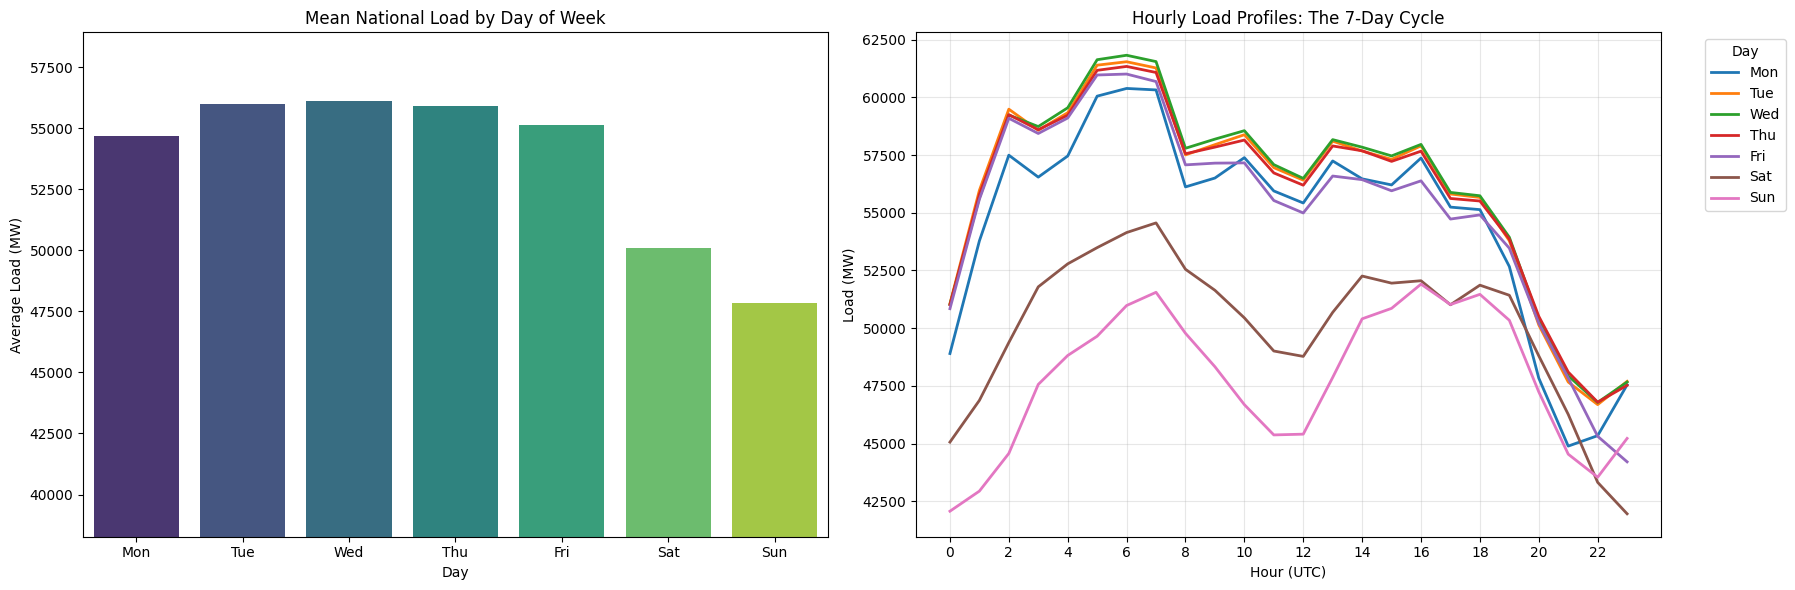

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_weekly_structure():
    print(">>> 5.2 WEEKLY STRUCTURE ANALYSIS")
    
    # 1. Load Data
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    if not files: return

    print(f"Aggregating {len(files)} years of data...")
    
    df_list = []
    for f in files:
        try:
            # Load subset
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={date_col: 'ts', val_col: 'mw'})
            temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
            
            # Extract features
            temp['dow'] = temp['ts'].dt.dayofweek # 0=Mon, 6=Sun
            temp['hour'] = temp['ts'].dt.hour
            
            # Aggregation: Mean load per (DayOfWeek, Hour)
            agg = temp.groupby(['dow', 'hour'])['mw'].mean().reset_index()
            df_list.append(agg)
            
        except Exception as e:
            print(f"Skipping {f}: {e}")

    if not df_list: return
    
    # 2. Final Aggregation
    df_all = pd.concat(df_list)
    # Average of averages (sufficient for profile shape)
    weekly_profile = df_all.groupby(['dow', 'hour'])['mw'].mean().reset_index()
    
    # Map Day Names for plotting
    days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    weekly_profile['day_name'] = weekly_profile['dow'].map(days)
    
    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot A: Average Load by Day of Week (Bar Chart)
    # We group by DOW only
    daily_means = weekly_profile.groupby('dow')['mw'].mean()
    sns.barplot(x=daily_means.index.map(days), y=daily_means.values, ax=ax1, palette="viridis")
    ax1.set_title("Mean National Load by Day of Week")
    ax1.set_ylabel("Average Load (MW)")
    ax1.set_xlabel("Day")
    ax1.set_ylim(bottom=min(daily_means.values)*0.8) # Zoom in to see difference
    
    # Plot B: Hourly Profile by Day (7 Lines)
    # We pivot for easier plotting
    sns.lineplot(data=weekly_profile, x='hour', y='mw', hue='day_name', 
                 palette='tab10', linewidth=2, ax=ax2)
    
    ax2.set_title("Hourly Load Profiles: The 7-Day Cycle")
    ax2.set_ylabel("Load (MW)")
    ax2.set_xlabel("Hour (UTC)")
    ax2.set_xticks(range(0, 24, 2))
    ax2.grid(True, alpha=0.3)
    ax2.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

    # Cleanup
    del df_all, df_list, weekly_profile
    gc.collect()

analyze_weekly_structure()

# 6. Seasonal patterns (load)


## 6.1 Monthly seasonality


- Monthly averages
- Monthly boxplots


>>> 6.1 SEASONAL PATTERNS: MONTHLY SEASONALITY
Aggregating 30 years of data...


/tmp/ipykernel_14007/1400742160.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list)
/tmp/ipykernel_14007/1400742160.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x='month', y='mw', palette="coolwarm", ax=ax2)


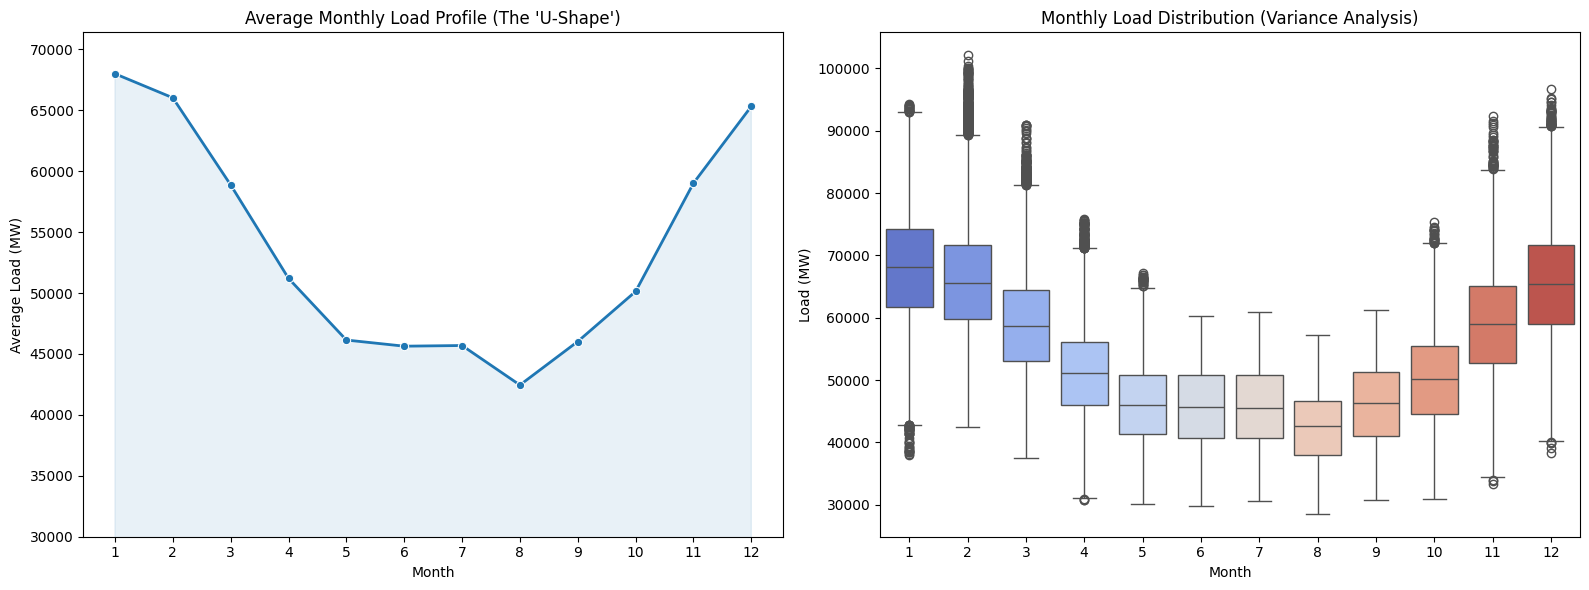

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_monthly_seasonality():
    print(">>> 6.1 SEASONAL PATTERNS: MONTHLY SEASONALITY")
    
    # 1. Load Data
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    if not files: return

    print(f"Aggregating {len(files)} years of data...")
    
    df_list = []
    for f in files:
        try:
            # Load subset
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={date_col: 'ts', val_col: 'mw'})
            temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
            
            # Extract Month
            temp['month'] = temp['ts'].dt.month
            
            # We can downsample to daily mean to speed up boxplots without losing distribution shape
            # or keep hourly. Let's keep hourly for full variance.
            # To save memory, we can select relevant columns only.
            df_list.append(temp[['month', 'mw']])
            
        except Exception as e:
            print(f"Skipping {f}: {e}")

    if not df_list: return
    
    # 2. Concatenate
    df_all = pd.concat(df_list)
    
    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot A: Average Load by Month (Line/Bar)
    monthly_means = df_all.groupby('month')['mw'].mean()
    sns.lineplot(x=monthly_means.index, y=monthly_means.values, marker='o', color='#1f77b4', linewidth=2, ax=ax1)
    ax1.fill_between(monthly_means.index, 0, monthly_means.values, color='#1f77b4', alpha=0.1)
    ax1.set_title("Average Monthly Load Profile (The 'U-Shape')")
    ax1.set_ylabel("Average Load (MW)")
    ax1.set_xlabel("Month")
    ax1.set_xticks(range(1, 13))
    ax1.set_ylim(bottom=30000)
    
    # Plot B: Monthly Boxplots (Variance)
    sns.boxplot(data=df_all, x='month', y='mw', palette="coolwarm", ax=ax2)
    ax2.set_title("Monthly Load Distribution (Variance Analysis)")
    ax2.set_ylabel("Load (MW)")
    ax2.set_xlabel("Month")
    
    plt.tight_layout()
    plt.show()

    # Cleanup
    del df_all, df_list
    gc.collect()

analyze_monthly_seasonality()

## 6.2 Year-to-year comparison


- Same-month comparisons across years
- Structural break detection


>>> 6.2 SEASONAL PATTERNS: YEAR-TO-YEAR COMPARISON
Loading 30 years for comparison...


/tmp/ipykernel_14007/2826591574.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(df_list)


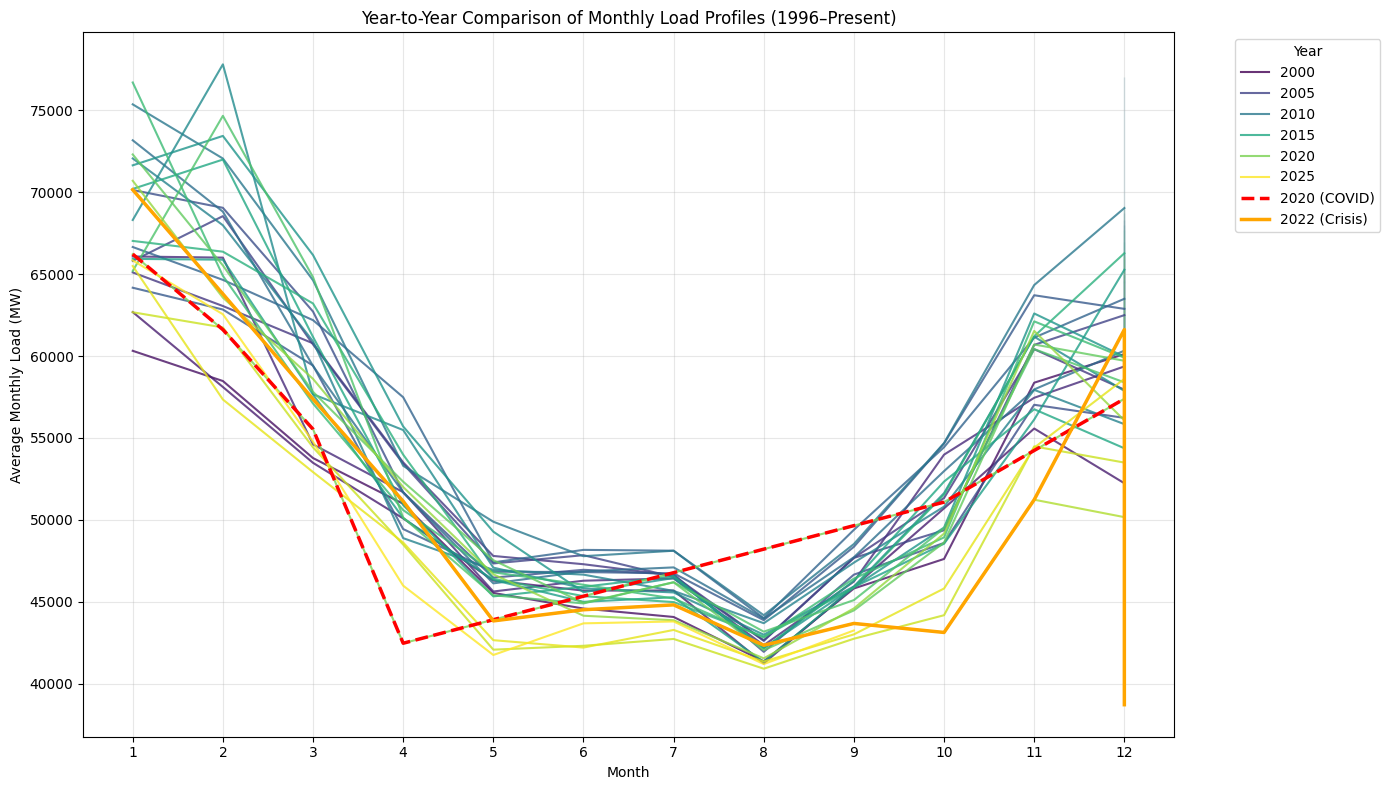

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_year_to_year_comparison():
    print(">>> 6.2 SEASONAL PATTERNS: YEAR-TO-YEAR COMPARISON")
    
    # 1. Load Data
    files = sorted(glob.glob("../data/interim/consommation/consommation_*_long_utc.csv"))
    if not files: return

    print(f"Loading {len(files)} years for comparison...")
    
    df_list = []
    for f in files:
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            temp = pd.read_csv(f, usecols=[date_col, val_col])
            temp = temp.rename(columns={date_col: 'ts', val_col: 'mw'})
            temp['ts'] = pd.to_datetime(temp['ts'], utc=True)
            
            # Extract features
            temp['year'] = temp['ts'].dt.year
            temp['month'] = temp['ts'].dt.month
            
            # Aggregate to monthly mean per year
            agg = temp.groupby(['year', 'month'])['mw'].mean().reset_index()
            df_list.append(agg)
            
        except Exception as e:
            pass

    if not df_list: return
    df_all = pd.concat(df_list)
    
    # 2. Visualization
    plt.figure(figsize=(14, 8))
    
    # Create a line plot with a sequential palette
    # We treat 'year' as numerical to get a gradient, or categorical for distinct colors
    sns.lineplot(
        data=df_all, 
        x='month', 
        y='mw', 
        hue='year', 
        palette='viridis',  # Darker = More Recent
        linewidth=1.5,
        alpha=0.8
    )
    
    # Highlight Key Years manually for clarity
    # 2020 (COVID) - Red Dashed
    df_2020 = df_all[df_all['year'] == 2020]
    plt.plot(df_2020['month'], df_2020['mw'], color='red', linestyle='--', linewidth=2.5, label='2020 (COVID)')
    
    # 2022 (Energy Crisis Start) - Orange
    df_2022 = df_all[df_all['year'] == 2022]
    plt.plot(df_2022['month'], df_2022['mw'], color='orange', linewidth=2.5, label='2022 (Crisis)')
    
    plt.title("Year-to-Year Comparison of Monthly Load Profiles (1996–Present)")
    plt.ylabel("Average Monthly Load (MW)")
    plt.xlabel("Month")
    plt.xticks(range(1, 13))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Year")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Cleanup
    del df_all, df_list
    gc.collect()

analyze_year_to_year_comparison()

# 7. Thermo-sensitivity analysis


## 7.1 Load vs temperature


- Scatter plots
- Nonlinear smoothing
- Winter vs summer asymmetry


>>> 7.1 THERMO-SENSITIVITY: LOAD VS TEMP
Loading data for years: [2019, 2020, 2021, 2022, 2023]...
Merged Data Points: 38,653


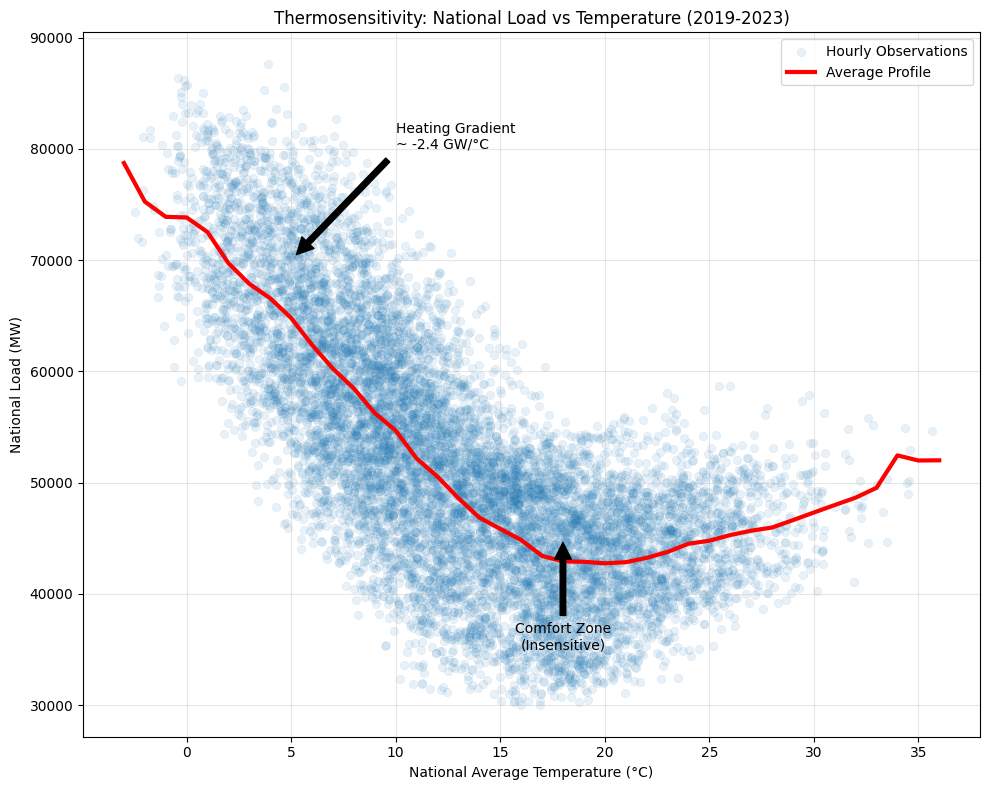

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_thermosensitivity():
    print(">>> 7.1 THERMO-SENSITIVITY: LOAD VS TEMP")
    
    # 1. Select Recent Years (e.g., 2019-2023) for relevant analysis
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading data for years: {years}...")
    
    # --- A. Load Consumption ---
    conso_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            # Check cols
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            conso_list.append(df)
        except: pass
    
    if not conso_list: return
    df_conso = pd.concat(conso_list).sort_values('ts').set_index('ts')
    
    # Resample Conso to Hourly (to match Weather)
    df_conso_h = df_conso.resample('h').mean().dropna()
    
    # --- B. Load Weather (and aggregate to National Mean) ---
    weather_list = []
    for y in years:
        f = f"../data/raw/weather/weather_32_cities_{y}.csv"
        try:
            # We take mean of all cities for a simple proxy
            df = pd.read_csv(f, usecols=['date', 'temperature_2m'])
            df['ts'] = pd.to_datetime(df['date'], utc=True)
            
            # Group by Timestamp (Average across 32 cities per hour)
            # This creates a "National Average Temperature"
            df_nat = df.groupby('ts')['temperature_2m'].mean()
            weather_list.append(df_nat)
        except: pass
        
    if not weather_list: return
    df_weather_h = pd.concat(weather_list).sort_index()
    
    # --- C. Merge ---
    # Inner join on index (Hour)
    df_merged = pd.merge(df_conso_h, df_weather_h, left_index=True, right_index=True)
    df_merged = df_merged.rename(columns={'temperature_2m': 'temp'})
    
    print(f"Merged Data Points: {len(df_merged):,}")
    
    # --- D. Visualization ---
    plt.figure(figsize=(10, 8))
    
    # 1. Scatter Plot with density (hexbin is faster/cleaner for large data)
    # But scatterplot with alpha is requested. We use a subset for plotting speed if huge.
    plot_data = df_merged.sample(min(10000, len(df_merged))) # Sample for plotting
    
    sns.scatterplot(
        data=plot_data, 
        x='temp', 
        y='mw', 
        alpha=0.1, 
        color='#1f77b4', 
        edgecolor=None, 
        label='Hourly Observations'
    )
    
    # 2. Non-linear Smoothing (The "Trend")
    # We bin temperature by 1°C steps to draw a clean mean line
    df_merged['temp_bin'] = df_merged['temp'].round()
    trend = df_merged.groupby('temp_bin')['mw'].mean().reset_index()
    
    plt.plot(trend['temp_bin'], trend['mw'], color='red', linewidth=3, label='Average Profile')
    
    plt.title("Thermosensitivity: National Load vs Temperature (2019-2023)")
    plt.xlabel("National Average Temperature (°C)")
    plt.ylabel("National Load (MW)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Annotation for Slope
    plt.annotate("Heating Gradient\n~ -2.4 GW/°C", 
                 xy=(5, 70000), xytext=(10, 80000),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.annotate("Comfort Zone\n(Insensitive)", 
                 xy=(18, 45000), xytext=(18, 35000),
                 arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

    plt.tight_layout()
    plt.show()

    # Cleanup
    del df_conso, df_weather_h, df_merged, conso_list, weather_list
    gc.collect()

analyze_thermosensitivity()

## 7.2 Degree-days


- Heating Degree Days (HDD)
- Cooling Degree Days (CDD)
- Comparison with raw temperature


In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc
import numpy as np

def analyze_degree_days():
    print(">>> 7.2 DEGREE-DAYS ANALYSIS (HDD/CDD)")
    
    # 1. Configuration
    # We use daily aggregation to compute standard "Degree-Days"
    years = [2019, 2020, 2021, 2022, 2023]
    T_REF_HEAT = 15.0  # Threshold below which heating starts
    T_REF_COOL = 18.0  # Threshold above which cooling starts
    
    print(f"Aggregating Daily Data for years: {years}...")
    
    # --- A. Load Consumption (Daily Mean) ---
    conso_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Resample to Daily Mean
            daily = df.set_index('ts').resample('D')['mw'].mean()
            conso_list.append(daily)
        except: pass
    
    if not conso_list: return
    df_conso = pd.concat(conso_list)
    
    # --- B. Load Weather (Daily Mean) ---
    weather_list = []
    for y in years:
        f = f"../data/raw/weather/weather_32_cities_{y}.csv"
        try:
            df = pd.read_csv(f, usecols=['date', 'temperature_2m'])
            df['ts'] = pd.to_datetime(df['date'], utc=True)
            
            # National Daily Mean Temp
            daily = df.groupby(df['ts'].dt.date)['temperature_2m'].mean()
            # Convert index to datetime for merging
            daily.index = pd.to_datetime(daily.index).tz_localize('UTC')
            weather_list.append(daily)
        except: pass
        
    if not weather_list: return
    df_weather = pd.concat(weather_list)
    
    # --- C. Merge & Feature Engineering ---
    df = pd.concat([df_conso, df_weather], axis=1).dropna()
    df.columns = ['load_mw', 'temp']
    
    # Calculate Degree Days
    df['HDD'] = (T_REF_HEAT - df['temp']).clip(lower=0)
    df['CDD'] = (df['temp'] - T_REF_COOL).clip(lower=0)
    
    print(f"Data Points (Daily): {len(df):,}")
    
    # --- D. Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Raw Temp vs Load (The V-Shape)
    sns.scatterplot(data=df, x='temp', y='load_mw', alpha=0.3, ax=axes[0], color='gray')
    axes[0].set_title("1. Raw Temperature (Non-Linear)")
    axes[0].set_xlabel("Temperature (°C)")
    axes[0].set_ylabel("Daily Load (MW)")
    
    # Plot 2: HDD vs Load (Linearized)
    # We filter only days where HDD > 0 to show the correlation slope
    sns.scatterplot(data=df[df['HDD']>0], x='HDD', y='load_mw', alpha=0.3, ax=axes[1], color='#d62728')
    
    # Add trendline
    if len(df[df['HDD']>0]) > 1:
        sns.regplot(data=df[df['HDD']>0], x='HDD', y='load_mw', scatter=False, ax=axes[1], color='black', line_kws={'linestyle':'--'})
    
    axes[1].set_title(f"2. Heating Degree Days (HDD)\nThreshold {T_REF_HEAT}°C")
    axes[1].set_xlabel("HDD (°C below threshold)")
    axes[1].set_ylabel("Daily Load (MW)")
    
    # Plot 3: CDD vs Load (Cooling effect)
    sns.scatterplot(data=df[df['CDD']>0], x='CDD', y='load_mw', alpha=0.4, ax=axes[2], color='#1f77b4')
    if len(df[df['CDD']>0]) > 1:
        sns.regplot(data=df[df['CDD']>0], x='CDD', y='load_mw', scatter=False, ax=axes[2], color='black', line_kws={'linestyle':'--'})
        
    axes[2].set_title(f"3. Cooling Degree Days (CDD)\nThreshold {T_REF_COOL}°C")
    axes[2].set_xlabel("CDD (°C above threshold)")
    axes[2].set_ylabel("Daily Load (MW)")
    
    plt.tight_layout()
    plt.show()
    
    # --- E. Correlation Check ---
    corr_temp = df.corr()['load_mw']['temp']
    corr_hdd = df.corr()['load_mw']['HDD']
    
    print(f"\n--- Correlation Analysis (Pearson) ---")
    print(f"Raw Temp Correlation: {corr_temp:.3f} (Negative, Non-linear mix)")
    print(f"HDD Correlation:      {corr_hdd:.3f} (Strong Positive Linear)")
    print("Conclusion: HDD is a superior feature for linear modeling.")

    # Cleanup
    del df, df_conso, df_weather, conso_list, weather_list
    gc.collect()

analyze_degree_days()

>>> 7.2 DEGREE-DAYS ANALYSIS (HDD/CDD)
Aggregating Daily Data for years: [2019, 2020, 2021, 2022, 2023]...


ValueError: cannot reindex on an axis with duplicate labels

## 7.3 Thermal inertia


- Lagged or smoothed temperature features


In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import gc

def analyze_thermal_inertia():
    print(">>> 7.3 THERMAL INERTIA ANALYSIS")
    
    # 1. Load Recent Data (Daily Mean)
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading data for years: {years}...")
    
    # --- A. Load Consumption ---
    conso_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'mw'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            conso_list.append(df.set_index('ts').resample('D')['mw'].mean())
        except: pass
    
    if not conso_list: return
    df_conso = pd.concat(conso_list)
    
    # --- B. Load Weather ---
    weather_list = []
    for y in years:
        f = f"../data/raw/weather/weather_32_cities_{y}.csv"
        try:
            df = pd.read_csv(f, usecols=['date', 'temperature_2m'])
            df['ts'] = pd.to_datetime(df['date'], utc=True)
            # Daily Mean Temp
            daily = df.groupby(df['ts'].dt.date)['temperature_2m'].mean()
            daily.index = pd.to_datetime(daily.index).tz_localize('UTC')
            weather_list.append(daily)
        except: pass
        
    if not weather_list: return
    df_weather = pd.concat(weather_list)
    
    # --- C. Feature Engineering (Thermal Inertia) ---
    df = pd.concat([df_conso, df_weather], axis=1).dropna()
    df.columns = ['load_mw', 'temp_raw']
    
    # Create "Smoothed" Temperatures (Exponential Moving Average)
    # Span=3 implies roughly taking the last 3 days into account
    df['temp_smooth_3d'] = df['temp_raw'].ewm(span=3).mean()
    
    # Create HDD for both to compare fairness
    df['HDD_raw'] = (15 - df['temp_raw']).clip(lower=0)
    df['HDD_smooth'] = (15 - df['temp_smooth_3d']).clip(lower=0)
    
    # --- D. Correlations ---
    corr_raw = df['load_mw'].corr(df['HDD_raw'])
    corr_smooth = df['load_mw'].corr(df['HDD_smooth'])
    
    print(f"\n--- IMPACT OF THERMAL INERTIA (Correlation with Load) ---")
    print(f"Raw HDD Correlation:      {corr_raw:.4f}")
    print(f"Smoothed HDD Correlation: {corr_smooth:.4f}")
    print(f"Improvement:             +{(corr_smooth - corr_raw):.4f}")
    
    # --- E. Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Raw Temperature Scatter
    # Filter for Winter only (HDD > 0) to see the effect clearly
    winter_mask = df['HDD_smooth'] > 0
    
    sns.scatterplot(data=df[winter_mask], x='HDD_raw', y='load_mw', 
                    alpha=0.3, ax=axes[0], color='gray')
    axes[0].set_title(f"Raw HDD vs Load\nCorr: {corr_raw:.3f}")
    axes[0].set_xlabel("Heating Degree Days (Raw)")
    axes[0].set_ylabel("Load (MW)")
    
    # Plot 2: Smoothed Temperature Scatter
    sns.scatterplot(data=df[winter_mask], x='HDD_smooth', y='load_mw', 
                    alpha=0.3, ax=axes[1], color='#1f77b4')
    axes[1].set_title(f"Smoothed HDD (Thermal Inertia) vs Load\nCorr: {corr_smooth:.3f}")
    axes[1].set_xlabel("Heating Degree Days (Smoothed)")
    axes[1].set_ylabel("Load (MW)")
    
    plt.tight_layout()
    plt.show()

    # Cleanup
    del df, df_conso, df_weather
    gc.collect()

analyze_thermal_inertia()

>>> 7.3 THERMAL INERTIA ANALYSIS
Loading data for years: [2019, 2020, 2021, 2022, 2023]...


ValueError: cannot reindex on an axis with duplicate labels

# Part B — Production (supply side)


# 8. Electricity generation: overview


## 8.1 Total generation vs load


- Compare total generation and load
- Identify stress periods (imports/exports if available)


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc

def analyze_generation_vs_load():
    print(">>> 8.1 GENERATION VS LOAD ANALYSIS")
    
    # Focus on recent critical years
    years = [2019, 2020, 2021, 2022, 2023]
    print(f"Loading data for years: {years}...")
    
    # --- 1. Load Consumption (Demand) ---
    conso_list = []
    for y in years:
        f = f"../data/interim/consommation/consommation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            val_col = 'load_mw' if 'load_mw' in cols else 'consumption_mw'
            
            df = pd.read_csv(f, usecols=[date_col, val_col])
            df = df.rename(columns={date_col: 'ts', val_col: 'load'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            # Resample to Daily Mean
            conso_list.append(df.set_index('ts').resample('D')['load'].mean())
        except: pass
        
    if not conso_list: return
    df_load = pd.concat(conso_list)

    # --- 2. Load Production (Supply) ---
    prod_list = []
    for y in years:
        f = f"../data/interim/production/production_realisation_{y}_long_utc.csv"
        try:
            cols = pd.read_csv(f, nrows=0).columns
            date_col = 'datetime' if 'datetime' in cols else 'start_date'
            
            df = pd.read_csv(f, usecols=[date_col, 'value_mw'])
            df = df.rename(columns={date_col: 'ts', 'value_mw': 'gen'})
            df['ts'] = pd.to_datetime(df['ts'], utc=True)
            
            # Sum ALL technologies per timestamp (Total Generation)
            # Then resample to Daily Mean
            total_gen = df.groupby('ts')['gen'].sum().resample('D').mean()
            prod_list.append(total_gen)
        except: pass
        
    if not prod_list: return
    df_gen = pd.concat(prod_list)

    # --- 3. Merge & Calculate Balance ---
    df = pd.concat([df_load, df_gen], axis=1).dropna()
    df.columns = ['Load', 'Generation']
    
    df['Balance'] = df['Generation'] - df['Load']
    
    # --- 4. Visualization ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # Plot A: Line Chart (Load vs Gen)
    ax1.plot(df.index, df['Load'], color='black', linewidth=1, label='National Load', alpha=0.7)
    ax1.plot(df.index, df['Generation'], color='#1f77b4', linewidth=1, label='Total Generation', alpha=0.9)
    ax1.set_title("Daily Average: Generation vs Load (2019–2023)")
    ax1.set_ylabel("Power (MW)")
    ax1.legend(loc="upper right")
    ax1.grid(True, alpha=0.3)
    
    # Plot B: Net Balance (Import/Export)
    # Fill positive (Export) in Green, negative (Import) in Red
    ax2.fill_between(df.index, df['Balance'], 0, where=(df['Balance'] >= 0), 
                     facecolor='green', alpha=0.5, interpolate=True, label='Net Export (Surplus)')
    ax2.fill_between(df.index, df['Balance'], 0, where=(df['Balance'] < 0), 
                     facecolor='red', alpha=0.6, interpolate=True, label='Net Import (Deficit)')
    
    # Highlight 2022 Crisis
    ax2.axvspan(pd.Timestamp('2022-01-01', tz='UTC'), pd.Timestamp('2022-12-31', tz='UTC'), 
                color='red', alpha=0.1)
    ax2.text(pd.Timestamp('2022-06-01', tz='UTC'), -10000, "2022 Nuclear Crisis", ha='center', color='darkred', fontweight='bold')

    ax2.set_title("Net Balance (Generation - Load)")
    ax2.set_ylabel("Balance (MW)")
    ax2.set_xlabel("Date")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Stats
    imports = df[df['Balance'] < 0]
    print(f"\n--- BALANCE STATISTICS (2019-2023) ---")
    print(f"Days of Net Import: {len(imports)} days ({len(imports)/len(df):.1%} of time)")
    print(f"Max Export Peak:   +{df['Balance'].max():,.0f} MW")
    print(f"Max Import Peak:   {df['Balance'].min():,.0f} MW")

    del df, df_load, df_gen
    gc.collect()

analyze_generation_vs_load()

>>> 8.1 GENERATION VS LOAD ANALYSIS
Loading data for years: [2019, 2020, 2021, 2022, 2023]...


ValueError: cannot reindex on an axis with duplicate labels

## 8.2 Generation mix


- Average mix by technology
- Mix evolution over time


# 9. Production by technology


## 9.1 Wind


- Volatility
- Seasonal behavior
- Ramp rates


## 9.2 Solar


- Diurnal cycle
- Seasonal amplitude


# 10. Weather dependence (production)


## 10.1 Wind vs wind speed


- Scatter plots
- Binned averages


## 10.2 Solar vs radiation


- Scatter plots
- Solar vs hour of day


## 10.3 Seasonal weather effects


- Winter vs summer comparisons


# 11. Residual load and grid stress


## 11.1 Definition


Residual load = load − (wind + solar)


## 11.2 Residual load analysis


- Distribution
- Daily profile
- Extreme peaks


## 11.3 Comparison with raw load


- Tail behavior
- Interpretation for grid stress


# Cross-cutting analysis


# 12. Calendar effects


## 12.1 Weekday effects


- Mean differences by weekday
- Interaction with seasonality


## 12.2 Holidays and vacations


- Holiday vs non-holiday comparison
- Vacation-period effects


# 13. Temporal dependence


## 13.1 Autocorrelation


- ACF / PACF for load and residual load


## 13.2 Lag correlations


- Correlation at 24h, 48h, 168h


# 14. Feature relationships


## 14.1 Correlation heatmaps


- Load, weather, generation variables


## 14.2 Redundancy checks


- Multicollinearity inspection


# 15. EDA synthesis and modeling decisions


## 15.1 Main conclusions


Summarize confirmed patterns:
- Seasonality
- Nonlinearity
- Intermittency
- Temporal dependence


## 15.2 Modeling implications


- Target choice
- Feature set
- Data cleaning policy
- Backtesting strategy


# Appendix
